### Frameworks e Bibliotecas

In [115]:
# Imports

import pandas as pd
import numpy as np
import math
import warnings

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import locale

from statsmodels.tsa.seasonal import MSTL

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb

import pmdarima as pm

locale.setlocale(locale.LC_TIME, "pt_BR.UTF-8")
plt.rcParams["font.family"] = "Arial"
matplotlib.rcParams["mathtext.fontset"] = "custom"
matplotlib.rcParams["mathtext.bf"] = "Arial:bold"
matplotlib.rcParams["mathtext.it"] = "Arial:italic"

warnings.filterwarnings("ignore", category=UserWarning)

### Leitura dos Dados

In [116]:
df = pd.read_excel("../data/Desafio Inteligência (Cientista de Dados).xlsx")

### Limpeza dos Dados

In [117]:
df.categoria_veiculo = df.categoria_veiculo.replace(
    {"IntermediÃ¡rio": "Intermediário", "EconÃ´mico": "Econômico"}
)

for column_name in df.columns:
    if "Unnamed" in column_name:
        df.drop(column_name, axis=1, inplace=True)

df.drop(["cidade", "estado"], axis=1, inplace=True)

df.id_loja = df.id_loja.str.replace("LJ_", "Loja ")

rename_columns = {
    "data_inicio_locacao": "Data de Início da Locação",
    "duracao_locacao": "Duração da Locação",
    "dias_antecedencia": "Dias de Antecedência",
    "diaria_media": "Diária Média",
    "valor_total_locacao": "Valor Total da Locação",
    "id_loja": "ID da Loja",
    "id_contrato": "ID do Contrato",
    "categoria_veiculo": "Categoria do Veículo",
}

df.rename(columns=rename_columns, inplace=True)

numerical_columns = [
    "Duração da Locação",
    "Dias de Antecedência",
    "Diária Média",
    "Valor Total da Locação",
]
categorical_columns = ["ID da Loja", "ID do Contrato", "Categoria do Veículo"]

### Estatísticas Gerais

1. Qual a duração média de uma locação?
R: 6 dias

2. Qual o valor médio arrecadado por contrato?
R$ 761.95

3. Com quantos dias de antecedência, em média, os clientes reservam?
R: 15 dias


In [118]:
# Display Dataframe
# Visualização das principais estatísticas do conjunto de dados

display(df.head())
display(df.info())
display(df.describe())

,ID do Contrato,Data de Início da Locação,Duração da Locação,ID da Loja,Dias de Antecedência,Categoria do Veículo,Diária Média,Valor Total da Locação
0,CTR0000001,2022-01-27,8,Loja 01,13,Econômico,91.22,729.76
1,CTR0000002,2022-01-31,9,Loja 01,9,Intermediário,78.70,708.30
2,CTR0000003,2022-01-10,7,Loja 01,16,SUV,143.14,1001.98
3,CTR0000004,2022-01-28,7,Loja 01,4,Intermediário,135.86,951.02
4,CTR0000005,2022-01-28,9,Loja 01,9,Intermediário,104.02,936.18


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140249 entries, 0 to 140248
Data columns (total 8 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   ID do Contrato             140249 non-null  object        
 1   Data de Início da Locação  140249 non-null  datetime64[ns]
 2   Duração da Locação         140249 non-null  int64         
 3   ID da Loja                 140249 non-null  object        
 4   Dias de Antecedência       140249 non-null  int64         
 5   Categoria do Veículo       140249 non-null  object        
 6   Diária Média               140249 non-null  float64       
 7   Valor Total da Locação     140249 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(3)
memory usage: 8.6+ MB


None

,Data de Início da Locação,Duração da Locação,Dias de Antecedência,Diária Média,Valor Total da Locação
count,140249,140249.000000,140249.000000,140249.000000,140249.000000
mean,2023-03-13 18:31:13.553465600,6.347439,15.019287,120.045161,761.950563
min,2022-01-01 00:00:00,1.000000,0.000000,-5.190000,-31.140000
25%,2022-08-01 00:00:00,5.000000,7.000000,99.750000,516.800000
50%,2023-02-24 00:00:00,6.000000,15.000000,120.140000,728.560000
75%,2023-11-03 00:00:00,8.000000,23.000000,140.220000,970.740000
max,2024-06-30 00:00:00,16.000000,30.000000,259.860000,2875.800000
std,NaN,2.271802,8.943597,30.002451,339.808277


### Histogramas

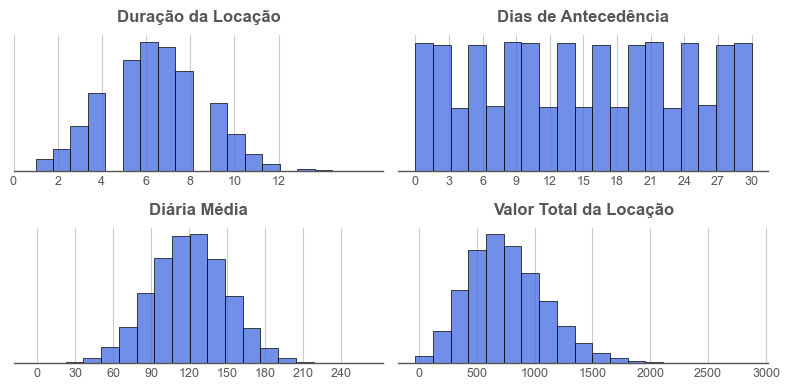

In [119]:
# Auxiliary Functions


def sturges_bins(x):
    x = np.asarray(x)
    x = x[~np.isnan(x)]
    n = len(x)
    if n <= 1:
        return 1, np.inf

    k = math.ceil(math.log2(n)) + 1
    data_range = x.max() - x.min()
    h = data_range / k if data_range > 0 else np.inf
    return k, h


def configure_histogram(ax, title_text):
    ax.tick_params(color="#555655")
    ax.spines["bottom"].set_color("#555655")
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    plt.setp(ax.get_xticklabels(), fontsize=9, color="#555655")
    ax.get_yaxis().set_visible(False)

    ax.set_xlabel("")
    ax.set_ylabel("")
    # Título
    ax.text(
        0.5,
        1.1,
        title_text,
        transform=ax.transAxes,
        fontsize=12,
        fontweight="semibold",
        color="#555655",
        ha="center",  # centraliza horizontalmente
    )

    plt.tight_layout()


# Plot

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8, 4), constrained_layout=True)
axes = axes.flatten()

for idx, col in enumerate(numerical_columns):
    k, h = sturges_bins(df.loc[:, col].values)
    sns.histplot(data=df, x=col, ax=axes[idx], bins=k, binwidth=h, linewidth=0.5, color="#4169E1")

    if col == "Duração da Locação":
        axes[idx].set_xticks(range(0, 14, 2))
    elif col == "Dias de Antecedência":
        axes[idx].set_xticks(range(0, 31, 3))
    elif col == "Diária Média":
        axes[idx].set_xticks(range(0, 251, 30))

    configure_histogram(ax=axes[idx], title_text=col)

plt.savefig("../img/results/histograms.png", dpi=600, bbox_inches="tight")

### Gráficos de Pareto

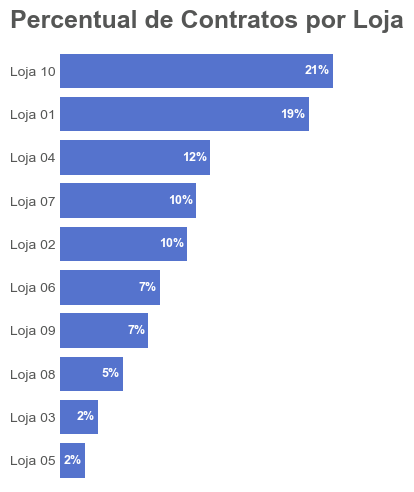

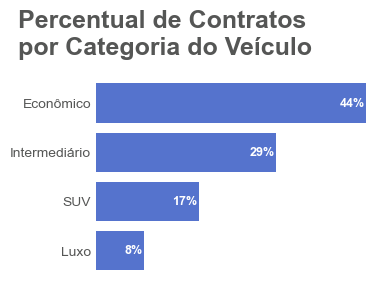

In [120]:
# Auxiliary Functions


def configure_pareto(ax, title_text, title_loc):
    ax.tick_params(color="#555655")
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["right"].set_visible(False)

    plt.setp(ax.get_yticklabels(), fontsize=10, color="#555655")
    ax.get_xaxis().set_visible(False)
    ax.tick_params(left=False)

    ax.set_xlabel("")
    ax.set_ylabel("")
    # Título
    ax.text(
        *title_loc,
        title_text,
        transform=ax.transAxes,
        fontsize=18,
        fontweight="semibold",
        color="#555655",
    )

    for p in ax.patches:
        percent = int(p.get_width() * 100)
        text = f"{percent}%"

        x = p.get_width() - 0.0025
        y = p.get_y() + p.get_height() / 2

        ax.text(
            x,
            y,
            text,
            fontweight="semibold",
            ha="right",
            va="center",
            fontsize=9,
            color="white",
        )

    plt.tight_layout()


# Plot

for col in categorical_columns:
    if col != "ID do Contrato":
        if col == "ID da Loja":
            title_text = "Percentual de Contratos por Loja"
            title_loc = (-0.175, 1.05)
            file_name = "store"
            fig, ax = plt.subplots(figsize=(4, 5), constrained_layout=True)
        else:
            title_text = "Percentual de Contratos \npor " + col
            title_loc = (-0.275, 1.125)
            file_name = "vehicle_category"
            fig, ax = plt.subplots(figsize=(4, 3), constrained_layout=True)

        rel_freq = df[col].value_counts(normalize=True).reset_index()
        rel_freq.columns = [col, "percent"]

        order = rel_freq[col]

        sns.barplot(
            data=rel_freq,
            y=col,
            x="percent",
            order=order,
            ax=ax,
            color="#4169E1",
        )

        configure_pareto(ax=ax, title_text=title_text, title_loc=title_loc)

        plt.savefig(f"../img/results/contracts_by_{file_name}.png", dpi=600, bbox_inches="tight")

### Análise de Desempenho e Rentabilidade

* Performance por Loja
* Performance por Categoria de Veículo

* Análise Cruzada: Qual é a categoria de veículo mais rentável em cada loja?

In [121]:
df_summary_stores = df.groupby("ID da Loja").agg(
    Quantidade_de_Contratos=("ID do Contrato", "count"),
    Receita_Total=("Valor Total da Locação", "sum"),
    Ticket_Medio=("Valor Total da Locação", "mean"),
    Diaria_Media=("Diária Média", "mean"),
    Duracao_Media_da_Locacao=("Duração da Locação", "mean"),
    Dias_de_Antecedencia_Media=("Dias de Antecedência", "mean"),
)

cols_to_round_and_convert = [
    "Receita_Total",
    "Ticket_Medio",
    "Diaria_Media",
    "Duracao_Media_da_Locacao",
    "Dias_de_Antecedencia_Media",
]

for col in cols_to_round_and_convert:
    df_summary_stores[col] = df_summary_stores[col].round(0).astype(int)

df_summary_stores.rename(
    columns={
        "ID da Loja": "Lojas",
        "Quantidade_de_Contratos": "Quantidade de Contratos",
        "Receita_Total": "Receita Total",
        "Ticket_Medio": "Ticket Médio",
        "Diaria_Media": "Diária Média",
        "Duracao_Media_da_Locacao": "Duração Média da Locação",
        "Dias_de_Antecedencia_Media": "Dias de Antecedência Média",
    },
    inplace=True,
)

display(df_summary_stores)

,Quantidade de Contratos,Receita Total,Ticket Médio,Diária Média,Duração Média da Locação,Dias de Antecedência Média
ID da Loja,,,,,,
Loja 01,27964,21335090,763,120,6,15
Loja 02,14253,10804280,758,120,6,15
Loja 03,4204,3191594,759,119,6,15
Loja 04,16843,12797305,760,120,6,15
Loja 05,2806,2097845,748,120,6,15
Loja 06,11215,8522087,760,120,6,15
Loja 07,15279,11685328,765,120,6,15
Loja 08,7051,5407191,767,120,6,15
Loja 09,9911,7571707,764,120,6,15


In [122]:
df_summary_vehicles = df.groupby("Categoria do Veículo").agg(
    Quantidade_de_Contratos=("Categoria do Veículo", "count"),
    Receita_Total=("Valor Total da Locação", "sum"),
    Ticket_Medio=("Valor Total da Locação", "mean"),
    Diaria_Media=("Diária Média", "mean"),
    Duracao_Media_da_Locacao=("Duração da Locação", "mean"),
    Dias_de_Antecedencia_Media=("Dias de Antecedência", "mean"),
)

cols_to_round_and_convert = [
    "Receita_Total",
    "Ticket_Medio",
    "Diaria_Media",
    "Duracao_Media_da_Locacao",
    "Dias_de_Antecedencia_Media",
]

for col in cols_to_round_and_convert:
    df_summary_vehicles[col] = df_summary_vehicles[col].round(0).astype(int)

df_summary_vehicles.rename(
    columns={
        "Quantidade_de_Contratos": "Quantidade de Contratos",
        "Receita_Total": "Receita Total",
        "Ticket_Medio": "Ticket Médio",
        "Diaria_Media": "Diária Média",
        "Duracao_Media_da_Locacao": "Duração Média da Locação",
        "Dias_de_Antecedencia_Media": "Dias de Antecedência Média",
    },
    inplace=True,
)

display(df_summary_vehicles)

,Quantidade de Contratos,Receita Total,Ticket Médio,Diária Média,Duração Média da Locação,Dias de Antecedência Média
Categoria do Veículo,,,,,,
Econômico,63071,48118073,763,120,6,15
Intermediário,41950,31933378,761,120,6,15
Luxo,11246,8612374,766,120,6,15
SUV,23982,18198979,759,120,6,15


In [123]:
df_rentability_total = (
    df.groupby(["ID da Loja", "Categoria do Veículo"])["Valor Total da Locação"]
    .sum()
    .reset_index()
)

idx_max_rentabilidade = df_rentability_total.groupby("ID da Loja")[
    "Valor Total da Locação"
].idxmax()

most_profitable_category_by_store = df_rentability_total.loc[idx_max_rentabilidade]
most_profitable_category_by_store["Valor Total da Locação"] = (
    most_profitable_category_by_store["Valor Total da Locação"].round(0).astype(int)
)
most_profitable_category_by_store.rename(
    columns={"Valor Total da Locação": "Valor Total de Locação"},
    inplace=True,
)

most_profitable_category_by_store = most_profitable_category_by_store.reset_index(
    drop=True
)

display(most_profitable_category_by_store)

,ID da Loja,Categoria do Veículo,Valor Total de Locação
0,Loja 01,Econômico,9478309
1,Loja 02,Econômico,4910746
2,Loja 03,Econômico,1459255
3,Loja 04,Econômico,5802909
4,Loja 05,Econômico,956739
5,Loja 06,Econômico,3778492
6,Loja 07,Econômico,5306427
7,Loja 08,Econômico,2394097
8,Loja 09,Econômico,3407965
9,Loja 10,Econômico,10623134


In [124]:
df_rentability_mean = (
    df.groupby(["ID da Loja", "Categoria do Veículo"])["Valor Total da Locação"]
    .mean()
    .reset_index()
)
idx_max_rentabilidade = df_rentability_mean.groupby("ID da Loja")[
    "Valor Total da Locação"
].idxmax()
most_profitable_category_by_store = df_rentability_mean.loc[idx_max_rentabilidade]
most_profitable_category_by_store["Valor Total da Locação"] = (
    most_profitable_category_by_store["Valor Total da Locação"].round(0).astype(int)
)

most_profitable_category_by_store.rename(
    columns={"Valor Total da Locação": "Ticket Médio"},
    inplace=True,
)

most_profitable_category_by_store = most_profitable_category_by_store.reset_index(
    drop=True
)

display(most_profitable_category_by_store)

,ID da Loja,Categoria do Veículo,Ticket Médio
0,Loja 01,SUV,765
1,Loja 02,Luxo,778
2,Loja 03,Intermediário,767
3,Loja 04,Luxo,778
4,Loja 05,Intermediário,761
5,Loja 06,SUV,766
6,Loja 07,Luxo,781
7,Loja 08,SUV,772
8,Loja 09,Luxo,770
9,Loja 10,Econômico,764


### Análise da Correlação das Variáveis

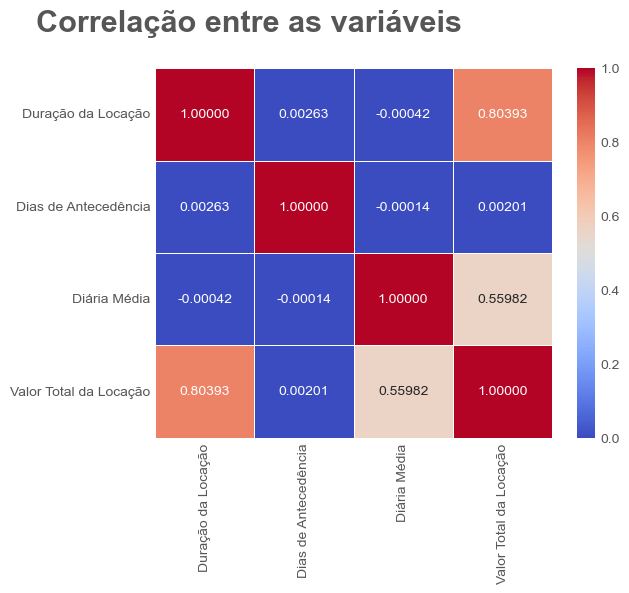

In [125]:
corr_matrix = df.loc[:, numerical_columns].corr()

plt.figure()
ax = sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".5f", linewidths=0.5)

plt.setp(
    [*ax.get_xticklabels(), *ax.get_yticklabels()], fontsize=10, color="#555655"
)
ax.tick_params(left=False, bottom=False)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(colors="#555655")

# Título
ax.text(
    -0.3, 1.1,
    "Correlação entre as variáveis",
    transform=ax.transAxes,
    fontsize=22,
    fontweight="semibold",
    color="#555655",
)

plt.savefig("../img/results/matrix_corr.png", dpi=600, bbox_inches="tight")


### Análise Temporal

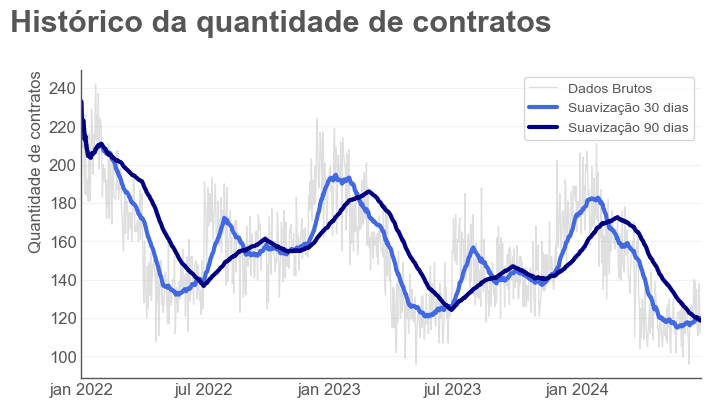

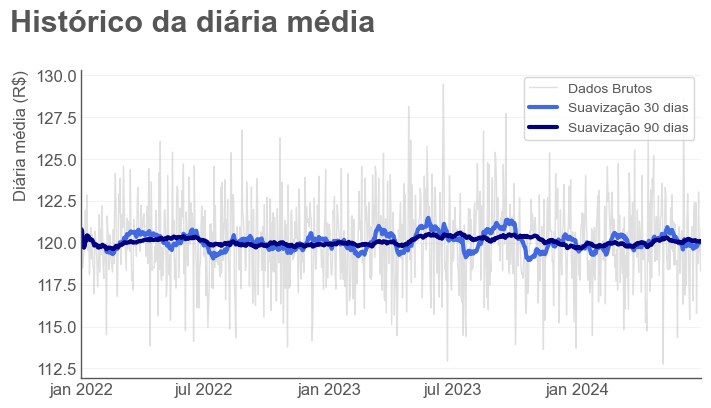

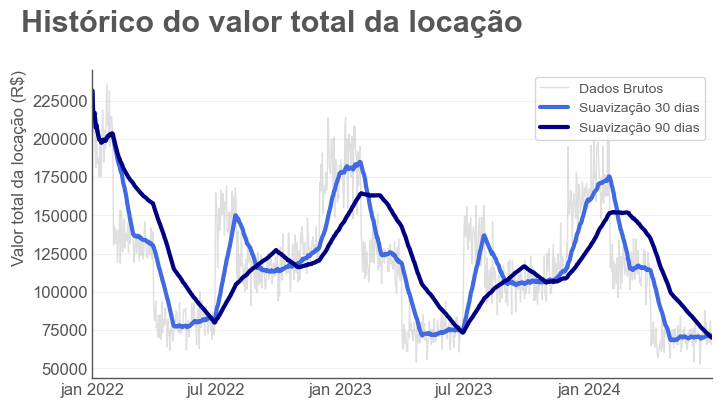

In [126]:
# Dados Brutos e Médias Móveis (Suavização)


def config_time_series_plot(ax, title: str, y_label: str, min_date, max_date):
    """
    Aplica uma configuração de estilo específica a um eixo Matplotlib.
    """
    # Define os limites do eixo X e o formato das datas
    ax.set_xlim(min_date, max_date)
    date_format = mdates.DateFormatter("%b %Y")  # Formato ex: "Jan 2023"
    ax.xaxis.set_major_formatter(date_format)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))  # Marca a cada 6 meses

    # Estiliza os ticks e as bordas (spines) do gráfico
    ax.tick_params(color="#555655")
    ax.spines["bottom"].set_color("#555655")
    ax.spines["left"].set_color("#555655")
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    # Configura o grid
    ax.grid(True, axis="y", alpha=0.25)
    ax.xaxis.grid(False)

    # Estiliza os rótulos dos ticks (números nos eixos)
    plt.setp(
        [*ax.get_xticklabels(), *ax.get_yticklabels()], fontsize=12, color="#555655"
    )

    # Configura os rótulos dos eixos e a legenda
    ax.set_xlabel("")
    ax.set_ylabel(y_label, loc="top", fontsize=12, color="#555655")
    ax.legend(title="", labelcolor="#555655", loc="upper right", frameon=True)

    # Adiciona o título principal com posicionamento customizado
    ax.text(
        -0.115,
        1.125,
        title,
        transform=ax.transAxes,
        fontsize=22,
        fontweight="semibold",
        color="#555655",
    )


def time_series_plot(
    df: pd.DataFrame, title: str, column: str, y_label: str, filename: str = None
):
    # Processamento dos Dados
    if column == "ID do Contrato":
        agg_function = "count"
    elif column == "Valor Total da Locação":
        agg_function = "sum"
    else:
        agg_function = "mean"

    df_time_series = (
        df.groupby(df["Data de Início da Locação"].dt.date)
        .agg({column: agg_function})
        .reset_index()
    )
    df_time_series.rename(
        columns={"Data de Início da Locação": "Data", column: "Dados Brutos"},
        inplace=True,
    )
    df_time_series["Data"] = pd.to_datetime(df_time_series["Data"])
    min_date = df_time_series["Data"].min()
    max_date = df_time_series["Data"].max()
    df_time_series.set_index("Data", inplace=True)

    # Cálculo
    df_time_series["Suavização 30 dias"] = (
        df_time_series["Dados Brutos"].rolling(window="30D").mean()
    )
    df_time_series["Suavização 90 dias"] = (
        df_time_series["Dados Brutos"].rolling(window="90D").mean()
    )

    # Plot
    fig, ax = plt.subplots(figsize=(8, 4))

    colors = {
        "Dados Brutos": "#C0C0C080",
        "Suavização 30 dias": "#4169E1",
        "Suavização 90 dias": "#000080",
    }
    widths = {"Dados Brutos": 1, "Suavização 30 dias": 3, "Suavização 90 dias": 3}

    for series_name in colors.keys():
        ax.plot(
            df_time_series.index,
            df_time_series[series_name],
            color=colors[series_name],
            linewidth=widths[series_name],
            label=series_name,
        )

    config_time_series_plot(ax, title, y_label, min_date, max_date)

    if filename:
        plt.savefig(f"../img/results/{filename}.png", dpi=600, bbox_inches="tight")


# Execution

time_series_plot(
    df,
    title="Histórico da quantidade de contratos",
    column="ID do Contrato",
    y_label="Quantidade de contratos",
    filename="history of the number of contracts".replace(" ", "_"),
)

time_series_plot(
    df,
    title="Histórico da diária média",
    column="Diária Média",
    y_label="Diária média (R$)",
    filename="history of the average daily rate".replace(" ", "_"),
)

time_series_plot(
    df,
    title="Histórico do valor total da locação",
    column="Valor Total da Locação",
    y_label="Valor total da locação (R$)",
    filename="total rental value history".replace(" ", "_"),
)

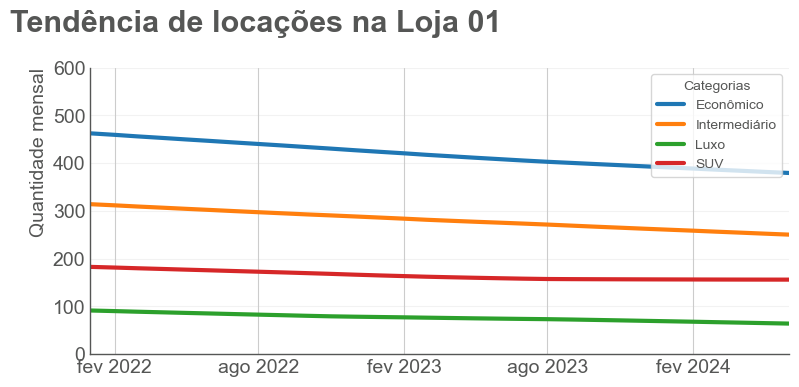

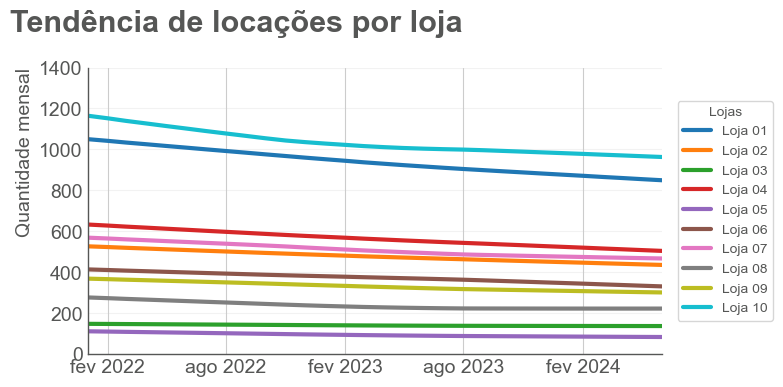

In [127]:
# Auxiliary Functions


def change_the_granularity_to_month(df: pd.DataFrame) -> pd.DataFrame:

    # Define as agregações a serem feitas
    aggregations = {
        "ID do Contrato": "count",
        "Diária Média": "mean",
        "Valor Total da Locação": "sum",
    }

    # Converte a coluna de data e cria a coluna 'mes'
    df_copy = df.copy()
    df_copy["Data de Início da Locação"] = pd.to_datetime(
        df_copy["Data de Início da Locação"]
    )
    df_copy["mes"] = df_copy["Data de Início da Locação"].dt.to_period("M")

    # Agrupa por mês, loja e categoria
    df_mensal = (
        df_copy.groupby(["mes", "ID da Loja", "Categoria do Veículo"])
        .agg(aggregations)
        .reset_index()
    )

    # Renomeia a coluna para refletir a contagem de contratos
    df_mensal = df_mensal.rename(columns={"ID do Contrato": "quantidade_contratos"})

    return df_mensal


def get_mstl_decomposition(df_single_series: pd.DataFrame, column: str):

    df_mstl = df_single_series[["mes", column]].copy()
    df_mstl["Data"] = df_mstl["mes"].dt.to_timestamp()
    df_mstl = df_mstl.set_index("Data")

    # Seleciona os períodos de sazonalidade com base no tamanho dos dados
    if len(df_mstl) >= 2 * 12:
        periods = [6, 12]
    elif len(df_mstl) >= 2 * 6:
        periods = [3, 6]
    else:
        periods = 3

    decomposition = MSTL(df_mstl[column], periods=periods).fit()

    return decomposition


def configure_trend_plot(
    ax,
    title_text,
    y_label,
    legend_title,
    min_date,
    max_date,
    y_upper_lim,
    legend_options,
    title_loc,
):
    ax.set_xlim(min_date, max_date)
    ax.set_ylim([0, int(1.1 * y_upper_lim)])

    date_format = mdates.DateFormatter("%b %Y")
    ax.xaxis.set_major_formatter(date_format)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))

    ax.tick_params(color="#555655")
    ax.spines["bottom"].set_color("#555655")
    ax.spines["left"].set_color("#555655")
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    ax.grid(axis="y", alpha=0.25)
    plt.setp(
        [*ax.get_xticklabels(), *ax.get_yticklabels()], fontsize=14, color="#555655"
    )

    leg = ax.legend(title=legend_title, labelcolor="#555655", frameon=True, **legend_options)
    leg.get_title().set_color("#555655")

    ax.set_xlabel("")
    ax.set_ylabel(y_label, loc="top", fontsize=14, color="#555655")
    ax.text(
        *title_loc,
        title_text,
        transform=ax.transAxes,
        fontsize=22,
        fontweight="semibold",
        color="#555655",
    )

    ax.set_ylim([0, max(ax.get_yticks())])
    plt.tight_layout()


def plot_trends_by_category(df_monthly, stores, vehicles):

    for store in stores:
        fig, ax = plt.subplots(figsize=(8, 4))
        y_upper_lim = 0

        store_data = df_monthly[df_monthly["ID da Loja"] == store]
        if store_data.empty:
            plt.close(fig)
            continue

        min_date = store_data["mes"].min().to_timestamp()
        max_date = store_data["mes"].max().to_timestamp()

        for vehicle in vehicles:
            df_filtered = store_data[
                store_data["Categoria do Veículo"] == vehicle
            ].copy()
            if df_filtered.empty:
                continue

            decomposition = get_mstl_decomposition(df_filtered, "quantidade_contratos")
            if decomposition is None:
                continue

            sns.lineplot(data=decomposition.trend, label=vehicle, ax=ax, linewidth=3)
            y_upper_lim = max(y_upper_lim, decomposition.trend.max())

        title = f"Tendência de locações na {store.replace('LJ', 'Loja')}"
        legend_opts = {"loc": "upper right"}

        configure_trend_plot(
            ax,
            title,
            "Quantidade mensal",
            "Categorias",
            min_date,
            max_date,
            y_upper_lim,
            legend_opts,
            title_loc=(-0.115, 1.125),
        )

        plt.savefig(f"../img/results/trend_amount_{store}.png", dpi=600)

        if store != "Loja 01":
            plt.close(fig)


def plot_trends_by_store(df_monthly, stores):

    df_by_store = (
        df_monthly.groupby(["mes", "ID da Loja"])["quantidade_contratos"]
        .sum()
        .reset_index()
    )

    fig, ax = plt.subplots(figsize=(8, 4))
    y_upper_lim = 0

    min_date = df_by_store["mes"].min().to_timestamp()
    max_date = df_by_store["mes"].max().to_timestamp()

    trend_variation = dict()

    for store in stores:
        df_filtered = df_by_store[df_by_store["ID da Loja"] == store].copy()
        if df_filtered.empty:
            continue

        decomposition = get_mstl_decomposition(df_filtered, "quantidade_contratos")
        if decomposition is None:
            continue

        sns.lineplot(
            data=decomposition.trend,
            label=store.replace("LJ ", "Loja "),
            ax=ax,
            linewidth=3,
        )
        y_upper_lim = max(y_upper_lim, decomposition.trend.max())

        trend_variation[store] = [
            decomposition.trend.iloc[0],
            decomposition.trend.iloc[-1],
            (decomposition.trend.iloc[-1] - decomposition.trend.iloc[0]) / decomposition.trend.iloc[0],
        ]

    title = "Tendência de locações por loja"
    legend_opts = {"loc": "center left", "bbox_to_anchor": (1.015, 0.5)}
    configure_trend_plot(
        ax,
        title,
        "Quantidade mensal",
        "Lojas",
        min_date,
        max_date,
        y_upper_lim,
        legend_opts,
        title_loc=(-0.135, 1.125),
    )

    plt.savefig("../img/results/trend_amount.png", bbox_inches="tight", dpi=600)
    
    return trend_variation


# Execution

# Data Preparation
df_monthly = change_the_granularity_to_month(df.copy())
stores = sorted(df["ID da Loja"].unique().tolist())
vehicles = sorted(df["Categoria do Veículo"].unique().tolist())

# Graph Generation
plot_trends_by_category(df_monthly, stores, vehicles)
trend_variation = plot_trends_by_store(df_monthly, stores)

In [128]:
df_trend_variation = pd.DataFrame.from_dict(
    trend_variation,
    orient="index",
    columns=["Valor Inicial", "Valor Final", "Variação"],
)
df_trend_variation.reset_index(inplace=True)
df_trend_variation.rename(columns={"index": "Loja"}, inplace=True)

df_trend_variation["Valor Inicial"] = df_trend_variation["Valor Inicial"].round(0).astype(int)
df_trend_variation["Valor Final"] = df_trend_variation["Valor Final"].round(0).astype(int)
df_trend_variation["Variação"] = df_trend_variation["Variação"].round(3)

display(df_trend_variation)

,Loja,Valor Inicial,Valor Final,Variação
0,Loja 01,1050,849,-0.191
1,Loja 02,527,436,-0.173
2,Loja 03,148,137,-0.073
3,Loja 04,633,504,-0.203
4,Loja 05,112,84,-0.250
5,Loja 06,414,331,-0.201
6,Loja 07,569,467,-0.179
7,Loja 08,277,223,-0.196
8,Loja 09,369,301,-0.183
9,Loja 10,1165,963,-0.173


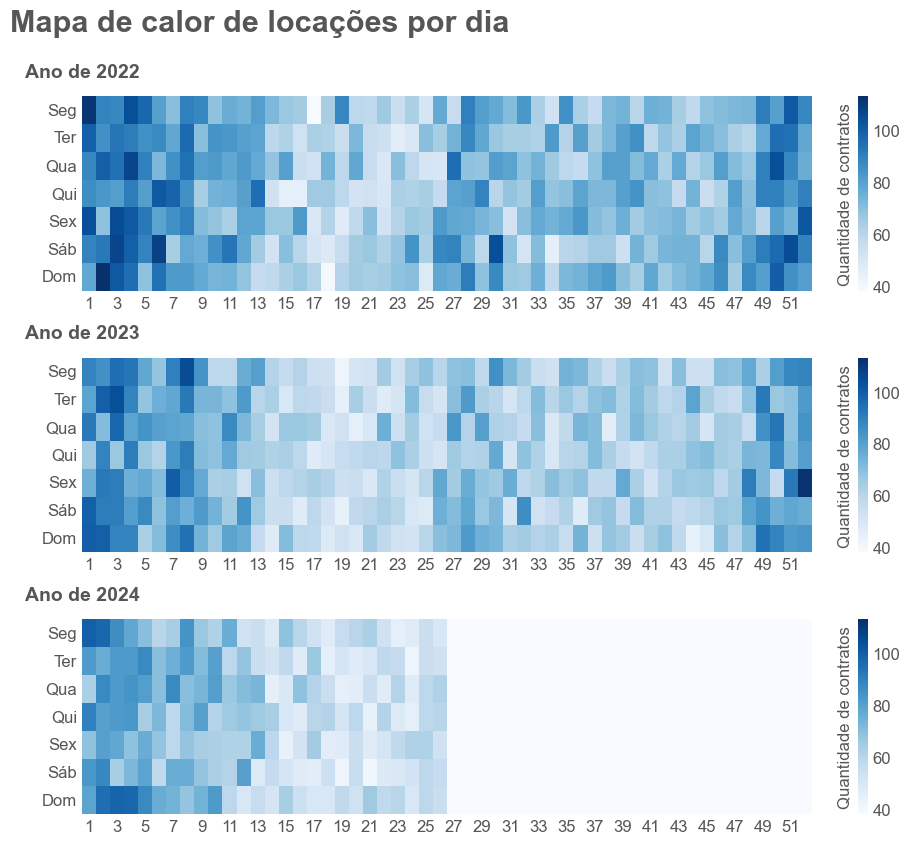

In [129]:
# Filtra Dataframe

# df_filtered = df.copy()
# df_filtered = df[df["ID da Loja"] == "Loja 05"].copy()
df_filtered = df[df["Categoria do Veículo"] == "Econômico"].copy()

# Processamento dos Dados

daily_counts = (
    df_filtered.groupby(df_filtered["Data de Início da Locação"].dt.date)
    .size()
    .reset_index(name="contagens")
)
daily_counts = daily_counts.rename(columns={"Data de Início da Locação": "data"})
daily_counts["data"] = pd.to_datetime(daily_counts["data"])

daily_counts["ano"] = daily_counts["data"].dt.year
daily_counts["semana_do_ano"] = daily_counts["data"].dt.isocalendar().week
daily_counts["dia_da_semana"] = daily_counts["data"].dt.dayofweek

vmin = daily_counts["contagens"].min()
vmax = daily_counts["contagens"].max()

anos = sorted(daily_counts["ano"].unique())

# Plot

fig, axes = plt.subplots(len(anos), 1, figsize=(10, 8), squeeze=False)

for i, ano in enumerate(anos):
    ax = axes[i, 0]
    df_year = daily_counts[daily_counts["ano"] == ano]

    # Cria a matriz (pivot table) para o heatmap
    # Linhas: dia da semana, Colunas: semana do ano, Valores: contagem de contratos
    heatmap_data = df_year.pivot_table(
        index="dia_da_semana",
        columns="semana_do_ano",
        values="contagens",
        fill_value=0,  # Preenche dias sem locações com 0
    )

    # Garante que todas as semanas (1-53) e dias (0-6) estejam presentes na matriz
    heatmap_data = heatmap_data.reindex(
        index=range(7), columns=range(1, 53), fill_value=0
    )

    # Desenha o mapa de calor usando os limites globais vmin e vmax
    cbar = sns.heatmap(
        heatmap_data,
        ax=ax,
        cmap="Blues",
        linewidths=0,
        vmin=vmin,
        vmax=vmax,
    )

    # Configurações do Plot

    plt.setp(
        [*ax.get_xticklabels(), *ax.get_yticklabels()], fontsize=12, color="#555655"
    )
    ax.tick_params(left=False, bottom=False)

    cbar = cbar.collections[0].colorbar
    cbar.set_label("Quantidade de contratos", size=12, color="#555655")
    cbar.ax.yaxis.set_label_position("left")
    cbar.ax.tick_params(labelsize=12, colors="#555655")

    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.text(
        0.0,
        1.1,
        f"Ano de {ano}",
        transform=ax.transAxes,
        fontsize=14,
        fontweight="semibold",
        color="#555655",
        ha="center",
    )

    dias_semana_labels = ["Seg", "Ter", "Qua", "Qui", "Sex", "Sáb", "Dom"]
    ax.set_yticklabels(dias_semana_labels, rotation=0)

fig.text(
    0.25,
    1.05,
    "Mapa de calor de locações por dia",
    ha="center",
    va="top",
    fontsize=22,
    fontweight="semibold",
    color="#555655",
)

plt.tight_layout()

plt.savefig("../img/results/heat_map.png", dpi=600, bbox_inches="tight")

### Análise Preditiva

#### Linear Model


Métricas de Avaliação do Linear Model:
  - MAE (Erro Absoluto Médio): 635.28
  - RMSE (Raiz do Erro Quadrático Médio): 720.48
  - MAPE (Erro Percentual Absoluto Médio): 14.49%


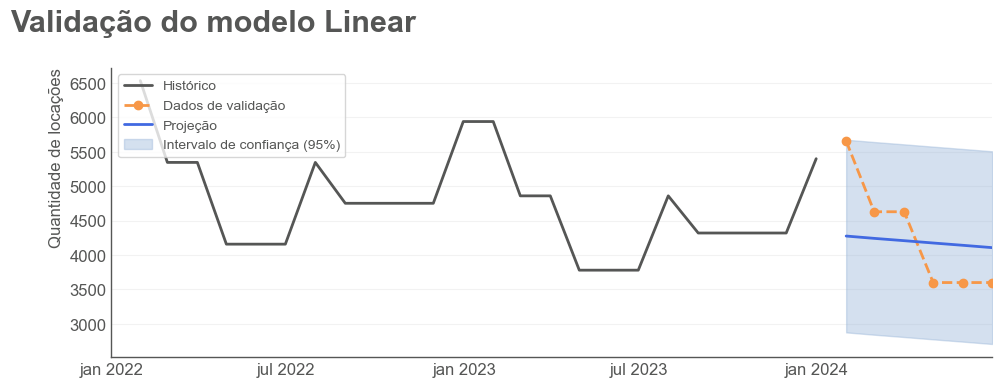

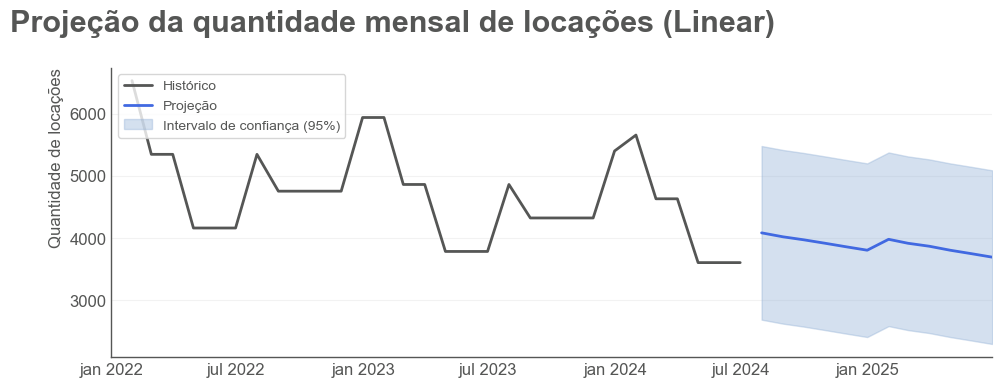

In [130]:
# Auxiliary Functions


def validation_linear(X, y, test_size=6):
    """
    Realiza o treinamento e avaliação de um modelo de Regressão Linear.
    """
    # Divisão dos dados em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, shuffle=False
    )

    # Treinamento do modelo de Regressão Linear
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)

    # Projeção no conjunto de teste
    y_pred = lr_model.predict(X_test)

    # Métricas de avaliação do modelo
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / np.where(y_test == 0, 1, y_test))) * 100

    print("\nMétricas de Avaliação do Linear Model:")
    print(f"  - MAE (Erro Absoluto Médio): {mae:.2f}")
    print(f"  - RMSE (Raiz do Erro Quadrático Médio): {rmse:.2f}")
    print(f"  - MAPE (Erro Percentual Absoluto Médio): {mape:.2f}%")

    # Cálculo do intervalo de confiança
    residuals = y_test - y_pred
    interval = 1.96 * np.std(residuals)
    lower_bound = y_pred - interval
    upper_bound = y_pred + interval

    return X_train, X_test, y_train, y_test, y_pred, interval, lower_bound, upper_bound


def model_linear(X, y, interval, start_date="2024-07-01", end_date="2025-06-30"):
    """
    Corrige a projeção.
    """
    # Treinamento do modelo com todos os dados históricos
    full_model = LinearRegression()
    full_model.fit(X, y)

    # Criação das datas futuras para a projeção
    future_dates = pd.date_range(start=start_date, end=end_date, freq="ME")
    future_df = pd.DataFrame(index=future_dates)

    future_df["time_index"] = np.arange(len(X), len(X) + len(future_dates))
    future_df["month"] = future_df.index.month
    future_df["year"] = future_df.index.year

    # Projeção
    future_projection = full_model.predict(future_df[["time_index", "month", "year"]])
    future_df["projection"] = future_projection

    # Cálculo do intervalo de confiança para a projeção
    lower_bound_future = future_projection - interval
    upper_bound_future = future_projection + interval

    return future_df, lower_bound_future, upper_bound_future


def config_prediction_plot(ax, title: str, y_label: str, min_date, max_date):
    """
    Aplica uma configuração de estilo específica a um eixo Matplotlib.
    """
    # Define os limites do eixo X e o formato das datas
    ax.set_xlim(min_date, max_date)
    date_format = mdates.DateFormatter("%b %Y")  # Formato ex: "Jan 2023"
    ax.xaxis.set_major_formatter(date_format)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))  # Marca a cada 6 meses

    # Estiliza os ticks e as bordas (spines) do gráfico
    ax.tick_params(color="#555655")
    ax.spines["bottom"].set_color("#555655")
    ax.spines["left"].set_color("#555655")
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    # Configura o grid
    ax.grid(True, axis="y", alpha=0.25)
    ax.xaxis.grid(False)

    # Estiliza os rótulos dos ticks (números nos eixos)
    plt.setp(
        [*ax.get_xticklabels(), *ax.get_yticklabels()], fontsize=12, color="#555655"
    )

    # Configura os rótulos dos eixos e a legenda
    ax.set_xlabel("")
    ax.set_ylabel(y_label, loc="top", fontsize=12, color="#555655")
    ax.legend(title="", labelcolor="#555655", loc="upper left", frameon=True)

    # Adiciona o título principal com posicionamento customizado
    ax.text(
        -0.115,
        1.125,
        title,
        transform=ax.transAxes,
        fontsize=22,
        fontweight="semibold",
        color="#555655",
    )
    plt.tight_layout()


def validation_linear_plot(
    X_train,
    X_test,
    y_train,
    y_test,
    y_pred,
    lower_bound,
    upper_bound,
    min_date,
    max_date,
):
    """
    Gera e salva o gráfico de validação do modelo.
    """
    fig, ax = plt.subplots(figsize=(10, 4))

    ax.plot(
        X_train.index, y_train, label="Histórico", color="#555655", linewidth=2
    )
    ax.plot(
        X_test.index,
        y_test,
        label="Dados de validação",
        color="#F79747",
        marker="o",
        linestyle="--",
        linewidth=2,
    )
    ax.plot(
        X_test.index,
        y_pred,
        label="Projeção",
        color="#4169E1",
        linewidth=2,
    )
    ax.fill_between(
        y_test.index,
        lower_bound,
        upper_bound,
        color="#94B2D7",
        alpha=0.4,
        label="Intervalo de confiança (95%)",
    )

    config_prediction_plot(
        ax,
        title="Validação do modelo Linear",
        y_label="Quantidade de locações",
        min_date=min_date,
        max_date=max_date,
    )

    # Salva a figura
    fig.savefig("../img/results/validation_linear.png", dpi=600, bbox_inches="tight")


def model_linear_plot(X, y, future_df, lower_bound, upper_bound, min_date):
    """
    Gera e salva o gráfico de projeção do modelo.
    """
    max_date = future_df.index.max()

    fig, ax = plt.subplots(figsize=(10, 4))

    ax.plot(
        X.index,
        y,
        label="Histórico",
        color="#555655",
        linewidth=2,
    )
    ax.plot(
        future_df.index,
        future_df["projection"],
        label="Projeção",
        color="#4169E1",
        linewidth=2,
    )
    ax.fill_between(
        future_df.index,
        lower_bound,
        upper_bound,
        color="#94B2D7",
        alpha=0.4,
        label="Intervalo de confiança (95%)",
    )

    config_prediction_plot(
        ax,
        title="Projeção da quantidade mensal de locações (Linear)",
        y_label="Quantidade de locações",
        min_date=min_date,
        max_date=max_date,
    )

    # Salva a figura
    fig.savefig(
        "../img/results/prediction_amount_linear.png", dpi=600, bbox_inches="tight"
    )


# Execution
# Preparação e Engenharia de Atributos

df["Data de Início da Locação"] = pd.to_datetime(df["Data de Início da Locação"])
min_date = df["Data de Início da Locação"].min()
max_date = df["Data de Início da Locação"].max()

# Mudança da escala/granulidade do conjunto de dados
df_monthly = (
    df.set_index("Data de Início da Locação")
    .resample("ME")
    .agg({"ID do Contrato": "count"})
    .rename(columns={"ID do Contrato": "Quantidade_Locacoes"})
)

# Criação dos atributos a partir do índice de data
df_monthly["time_index"] = np.arange(len(df_monthly))  # Tendência temporal
df_monthly["month"] = df_monthly.index.month  # Sazonalidade mensal
df_monthly["year"] = df_monthly.index.year  # Sazonalidade anual

# Definição das variáveis preditoras (X) e alvo (y)
X = df_monthly[["time_index", "month", "year"]]
y = df_monthly["Quantidade_Locacoes"]

# Treinamento e Validação do Modelo

X_train, X_test, y_train, y_test, y_pred, interval, lower_bound, upper_bound = (
    validation_linear(X, y, test_size=6)
)
validation_linear_plot(
    X_train,
    X_test,
    y_train,
    y_test,
    y_pred,
    lower_bound,
    upper_bound,
    min_date,
    max_date,
)

# Projeção

future_df, lower_bound_future, upper_bound_future = model_linear(X, y, interval)
model_linear_plot(X, y, future_df, lower_bound_future, upper_bound_future, min_date)

#### ARIMA

In [ ]:
# Auxiliary Functions


def validation_arima(
    y,
    test_size=6,
    m=12,
    start_p=1,
    start_q=1,
    max_p=3,
    max_q=3,
    start_P=0,
    D=1,
    trace=True,
    error_action="ignore",
    suppress_warnings=True,
    stepwise=True,
):
    """
    Realiza o treinamento, validação e avaliação de um modelo auto_arima para
    séries temporais.

    Args:
        y (pd.Series): Series com a variável alvo.
        test_size (int): Número de amostras a serem usadas como conjunto de teste.
        m (int): O ciclo sazonal do auto_arima (e.g., 12 para dados mensais).
        start_p (int): Ordem inicial do termo auto-regressivo (p).
        start_q (int): Ordem inicial do termo de média móvel (q).
        max_p (int): Ordem máxima do termo auto-regressivo (p).
        max_q (int): Ordem máxima do termo de média móvel (q).
        start_P (int): Ordem inicial do termo auto-regressivo sazonal (P).
        D (int): Ordem da diferenciação sazonal (D).
        trace (bool): Se True, exibe o log de auto_arima.
        error_action (str): Ação a ser tomada em caso de erro.
        suppress_warnings (bool): Se True, suprime os warnings.
        stepwise (bool): Se True, utiliza o método stepwise para busca.

    Returns:
        tuple: Uma tupla contendo:
            - y_train (pd.Series): Dados de treino da variável alvo.
            - y_test (pd.Series): Dados de teste da variável alvo.
            - y_pred (np.array): Previsões do modelo para o conjunto de teste.
            - lower_bound (np.array): Limite inferior do intervalo de confiança.
            - upper_bound (np.array): Limite superior do intervalo de confiança.
    """
    # Divisão dos dados em treino e teste
    y_train, y_test = y[:-test_size], y[-test_size:]

    # Treinamento do modelo
    best_model = pm.auto_arima(
        y_train,
        start_p=start_p,
        start_q=start_q,
        test="adf",
        max_p=max_p,
        max_q=max_q,
        m=m,
        d=None,
        seasonal=True,
        start_P=start_P,
        D=D,
        trace=trace,
        error_action=error_action,
        suppress_warnings=suppress_warnings,
        stepwise=stepwise,
    )
    print("\n--- Sumário do Modelo auto_arima ---")
    print(best_model.summary())

    # Previsões no período de teste
    y_pred, conf_int_test = best_model.predict(
        n_periods=len(y_test), return_conf_int=True
    )

    lower_bound = conf_int_test[:, 0]
    upper_bound = conf_int_test[:, 1]

    # Cálculo e exibição das métricas de avaliação
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / np.where(y_test == 0, 1, y_test))) * 100

    print("\n--- Métricas de Avaliação do Modelo (período de teste) ---")
    print(f"MAE (Erro Absoluto Médio): {mae:.2f}")
    print(f"RMSE (Raiz do Erro Quadrático Médio): {rmse:.2f}")
    print(f"MAPE (Erro Percentual Absoluto Médio): {mape:.2f}%")

    return y_train, y_test, y_pred, lower_bound, upper_bound


def model_arima(
    y,
    n_periods_future,
    start_p=1,
    start_q=1,
    max_p=3,
    max_q=3,
    m=12,
    start_P=0,
    D=1,
    trace=True,
    error_action="ignore",
    suppress_warnings=True,
    stepwise=True,
):
    """
    Treina o modelo auto_arima.

    Args:
        y (pd.Series): Series completa com todos os dados históricos.
        n_periods_future (int): Número de períodos no futuro para a projeção.
        start_p (int): Ordem inicial do termo auto-regressivo (p).
        start_q (int): Ordem inicial do termo de média móvel (q).
        max_p (int): Ordem máxima do termo auto-regressivo (p).
        max_q (int): Ordem máxima do termo de média móvel (q).
        m (int): O ciclo sazonal (e.g., 12 para dados mensais).
        start_P (int): Ordem inicial do termo auto-regressivo sazonal (P).
        D (int): Ordem da diferenciação sazonal (D).
        trace (bool): Se True, exibe o log de auto_arima.
        error_action (str): Ação a ser tomada em caso de erro.
        suppress_warnings (bool): Se True, suprime os warnings.
        stepwise (bool): Se True, utiliza o método stepwise para busca.

    Returns:
        tuple: Uma tupla contendo:
            - X_pred (pd.DatetimeIndex): Datas futuras da projeção.
            - y_pred (np.array): A projeção dos valores futuros.
            - lower_bound_future (np.array): Limite inferior do intervalo de confiança futuro.
            - upper_bound_future (np.array): Limite superior do intervalo de confiança futuro.
    """
    final_model = pm.auto_arima(
        y,
        start_p=start_p,
        start_q=start_q,
        test="adf",
        max_p=max_p,
        max_q=max_q,
        m=m,
        d=None,
        seasonal=True,
        start_P=start_P,
        D=D,
        trace=trace,
        error_action=error_action,
        suppress_warnings=suppress_warnings,
        stepwise=stepwise,
    )

    print("\n--- Sumário do Modelo Final auto_arima ---")
    print(final_model.summary())

    # Projeção dos valores e cálculo do intervalo de confiança
    y_pred, conf_int_future = final_model.predict(
        n_periods=n_periods_future, return_conf_int=True
    )

    lower_bound_future = conf_int_future[:, 0]
    upper_bound_future = conf_int_future[:, 1]

    # Geração das datas futuras
    X_pred = pd.date_range(
        start=y.index[-1] + pd.DateOffset(months=1),
        periods=n_periods_future,
        freq="ME",
    )

    return (
        X_pred,
        y_pred,
        lower_bound_future,
        upper_bound_future,
    )


def config_prediction_plot(ax, title: str, y_label: str, min_date, max_date):
    """
    Aplica uma configuração de estilo específica a um eixo Matplotlib.
    """
    # Define os limites do eixo X e o formato das datas
    ax.set_xlim(min_date, max_date)
    date_format = mdates.DateFormatter("%b %Y")  # Formato ex: "Jan 2023"
    ax.xaxis.set_major_formatter(date_format)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))  # Marca a cada 6 meses

    # Estiliza os ticks e as bordas (spines) do gráfico
    ax.tick_params(color="#555655")
    ax.spines["bottom"].set_color("#555655")
    ax.spines["left"].set_color("#555655")
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    # Configura o grid
    ax.grid(True, axis="y", alpha=0.25)
    ax.xaxis.grid(False)

    # Estiliza os rótulos dos ticks (números nos eixos)
    plt.setp(
        [*ax.get_xticklabels(), *ax.get_yticklabels()], fontsize=12, color="#555655"
    )

    # Configura os rótulos dos eixos e a legenda
    ax.set_xlabel("")
    ax.set_ylabel(y_label, loc="top", fontsize=12, color="#555655")
    ax.legend(title="", labelcolor="#555655", loc="upper left", frameon=True)

    # Adiciona o título principal com posicionamento customizado
    ax.text(
        -0.115,
        1.125,
        title,
        transform=ax.transAxes,
        fontsize=22,
        fontweight="semibold",
        color="#555655",
    )
    plt.tight_layout()


def validation_arima_plot(
    y_train, y_test, y_pred, lower_bound, upper_bound, min_date, max_date
):
    """
    Gera e salva o gráfico de validação do modelo ARIMA.
    """
    fig, ax = plt.subplots(figsize=(10, 4))

    ax.plot(y_train.index, y_train, label="Histórico", color="#555655", linewidth=2)
    ax.plot(
        y_test.index,
        y_test,
        label="Dados de validação",
        color="#F79747",
        marker="o",
        linestyle="--",
        linewidth=2,
    )
    ax.plot(
        y_test.index,
        y_pred,
        label="Projeção",
        color="#4169E1",
        linewidth=2,
    )
    ax.fill_between(
        y_test.index,
        lower_bound,
        upper_bound,
        color="#94B2D7",
        alpha=0.4,
        label="Intervalo de confiança (95%)",
    )

    config_prediction_plot(
        ax,
        title="Validação do modelo ARIMA",
        y_label="Quantidade de locações",
        min_date=min_date,
        max_date=max_date,
    )

    # Salva a figura
    fig.savefig("../img/results/validation_arima.png", dpi=600, bbox_inches="tight")


def model_arima_plot(
    y,
    X_pred,
    y_pred,
    lower_bound_future,
    upper_bound_future,
    min_date,
):
    """
    Gera o gráfico com os dados históricos e a projeção futura do modelo SARIMA.

    Args:
        y (pd.Series): Série com os dados históricos.
        X_pred (pd.DatetimeIndex): Datas futuras da projeção.
        y_pred (np.array): Projeções para o futuro.
        lower_bound_future (np.array): Limite inferior do intervalo de confiança.
        upper_bound_future (np.array): Limite superior do intervalo de confiança.
    """
    max_date = X_pred.max()

    fig, ax = plt.subplots(figsize=(10, 4))

    ax.plot(
        y.index,
        y,
        label="Histórico",
        color="#555655",
        linewidth=2,
    )
    ax.plot(
        X_pred,
        y_pred,
        label="Projeção",
        color="#4169E1",
        linewidth=2,
    )
    ax.fill_between(
        X_pred,
        lower_bound_future,
        upper_bound_future,
        color="#94B2D7",
        alpha=0.4,
        label="Intervalo de confiança (95%)",
    )

    config_prediction_plot(
        ax,
        title="Projeção da quantidade mensal de locações (ARIMA)",
        y_label="Quantidade de locações",
        min_date=min_date,
        max_date=max_date,
    )

    fig.savefig(
        "../img/results/prediction_amount_arima.png",
        dpi=600,
        bbox_inches="tight",
    )


# Execution

# Preparação dos Dados

df["Data de Início da Locação"] = pd.to_datetime(df["Data de Início da Locação"])
min_date = df["Data de Início da Locação"].min()
max_date = df["Data de Início da Locação"].max()

df_monthly = (
    df.set_index("Data de Início da Locação")
    .resample("ME")
    .agg({"ID do Contrato": "count"})
    .rename(columns={"ID do Contrato": "Quantidade_Locacoes"})
)

y = df_monthly["Quantidade_Locacoes"]

# Validação do Modelo com auto_arima

y_train, y_test, y_pred, lower_bound, upper_bound = validation_arima(y)
validation_arima_plot(
    y_train, y_test, y_pred, lower_bound, upper_bound, min_date, max_date
)

# Projeção

X_pred, y_pred, lower_bound_future, upper_bound_future = model_arima(
    y, n_periods_future=12
)

model_arima_plot(y, X_pred, y_pred, lower_bound_future, upper_bound_future, min_date)

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,1,1)[12]             : AIC=inf, Time=0.16 sec
 ARIMA(0,2,0)(0,1,0)[12]             : AIC=121.145, Time=0.02 sec
 ARIMA(1,2,0)(1,1,0)[12]             : AIC=inf, Time=0.17 sec
 ARIMA(0,2,1)(0,1,1)[12]             : AIC=inf, Time=0.11 sec
 ARIMA(0,2,0)(1,1,0)[12]             : AIC=inf, Time=0.12 sec
 ARIMA(0,2,0)(0,1,1)[12]             : AIC=inf, Time=0.05 sec
 ARIMA(0,2,0)(1,1,1)[12]             : AIC=123.319, Time=0.18 sec
 ARIMA(1,2,0)(0,1,0)[12]             : AIC=117.379, Time=0.02 sec
 ARIMA(1,2,0)(0,1,1)[12]             : AIC=inf, Time=0.09 sec
 ARIMA(1,2,0)(1,1,1)[12]             : AIC=118.832, Time=0.20 sec
 ARIMA(2,2,0)(0,1,0)[12]             : AIC=119.379, Time=0.03 sec
 ARIMA(1,2,1)(0,1,0)[12]             : AIC=119.378, Time=0.05 sec
 ARIMA(0,2,1)(0,1,0)[12]             : AIC=118.492, Time=0.03 sec
 ARIMA(2,2,1)(0,1,0)[12]             : AIC=121.033, Time=0.06 sec
 ARIMA(1,2,0)(0,1,0)[12] intercept   : AIC=118.390, Time=

#### Random Forest

Fitting 5 folds for each of 1125 candidates, totalling 5625 fits

Melhores parâmetros encontrados: RandomForestRegressor(max_depth=2, min_samples_leaf=2, min_samples_split=20,
                      n_estimators=2, random_state=42)

Métricas de Avaliação do Modelo Random Forest (período de teste)
MAE (Erro Absoluto Médio): 707.83
RMSE (Raiz do Erro Quadrático Médio): 853.98
MAPE (Erro Percentual Absoluto Médio): 17.92%


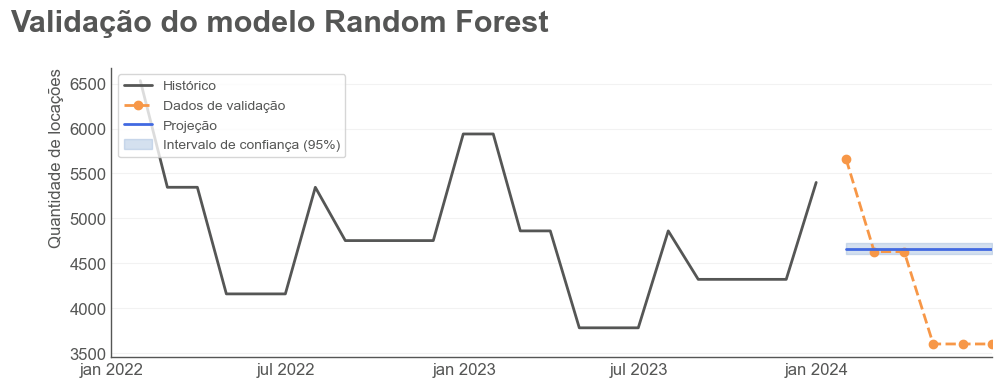

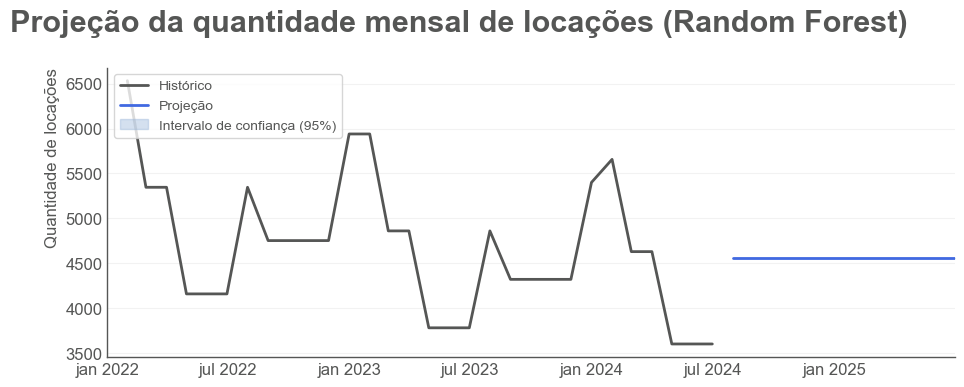

In [ ]:
# Auxiliary Functions


def prediction_interval(model, X_data):
    """
    Calcula o intervalo de confiança de 95% para as previsões de um modelo
    Random Forest a partir das predições de cada árvore individual.

    Args:
        model (RandomForestRegressor): O modelo Random Forest treinado.
        X_data (pd.DataFrame): Os dados de entrada para os quais a predição será feita.

    Returns:
        tuple: Uma tupla contendo o limite inferior e o limite superior do intervalo.
    """
    preds = np.array([tree.predict(X_data) for tree in model.estimators_])
    lower = np.percentile(preds, 2.5, axis=0)
    upper = np.percentile(preds, 97.5, axis=0)

    return lower, upper


def validation_randomforest(X, y, param_grid, test_size=6, random_state=42):
    """
    Realiza o treinamento e avalidação (com GridSearchCV) de um modelo
    Random Forest para séries temporais.
    """
    # Divisão dos dados em treino e teste, mantendo a ordem temporal
    X_train, X_test = X[:-test_size], X[-test_size:]
    y_train, y_test = y[:-test_size], y[-test_size:]

    # Validação cruzada específica para séries temporais
    tscv = TimeSeriesSplit(n_splits=5)

    # Configuração e execução do Grid Search
    grid_search = GridSearchCV(
        estimator=RandomForestRegressor(random_state=random_state),
        param_grid=param_grid,
        cv=tscv,
        scoring="neg_mean_squared_error",
        n_jobs=-1,
        verbose=1,
    )
    grid_search.fit(X_train, y_train)

    # Melhor modelo encontrado
    best_model = grid_search.best_estimator_
    print(f"\nMelhores parâmetros encontrados: {best_model}")

    # Projeção e cálculo do intervalo de confiança no conjunto de teste
    y_pred = best_model.predict(X_test)
    lower_bound, upper_bound = prediction_interval(best_model, X_test)

    # Cálculo e exibição das métricas de avaliação
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / np.where(y_test == 0, 1, y_test))) * 100

    print("\nMétricas de Avaliação do Modelo Random Forest (período de teste)")
    print(f"MAE (Erro Absoluto Médio): {mae:.2f}")
    print(f"RMSE (Raiz do Erro Quadrático Médio): {rmse:.2f}")
    print(f"MAPE (Erro Percentual Absoluto Médio): {mape:.2f}%")

    return (
        X_train,
        X_test,
        y_train,
        y_test,
        y_pred,
        best_model,
        lower_bound,
        upper_bound
    )


def model_randomforest(
    X, y, best_params, start_date="2024-07-01", end_date="2025-06-30"
):
    """
    Treina o modelo final com todos os dados e projeta valores futuros.
    """
    # Treinamento do modelo final com todos os dados
    final_model = RandomForestRegressor(**best_params.get_params())
    final_model.fit(X, y)

    # Criação das datas e features para o período futuro
    future_dates = pd.date_range(start=start_date, end=end_date, freq="ME")
    X_pred = pd.DataFrame(index=future_dates)
    X_pred["time_index"] = np.arange(len(X), len(X) + len(future_dates))
    X_pred["month"] = X_pred.index.month
    X_pred["year"] = X_pred.index.year

    # Projeção dos valores e cálculo do intervalo de confiança
    y_pred = final_model.predict(X_pred)
    lower_bound_future, upper_bound_future = prediction_interval(final_model, X_pred)

    return X_pred, y_pred, lower_bound_future, upper_bound_future


def config_prediction_plot(ax, title: str, y_label: str, min_date, max_date):
    """
    Aplica uma configuração de estilo específica a um eixo Matplotlib.
    """
    # Define os limites do eixo X e o formato das datas
    ax.set_xlim(min_date, max_date)
    date_format = mdates.DateFormatter("%b %Y")  # Formato ex: "Jan 2023"
    ax.xaxis.set_major_formatter(date_format)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))  # Marca a cada 6 meses

    # Estiliza os ticks e as bordas (spines) do gráfico
    ax.tick_params(color="#555655")
    ax.spines["bottom"].set_color("#555655")
    ax.spines["left"].set_color("#555655")
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    # Configura o grid
    ax.grid(True, axis="y", alpha=0.25)
    ax.xaxis.grid(False)

    # Estiliza os rótulos dos ticks (números nos eixos)
    plt.setp(
        [*ax.get_xticklabels(), *ax.get_yticklabels()], fontsize=12, color="#555655"
    )

    # Configura os rótulos dos eixos e a legenda
    ax.set_xlabel("")
    ax.set_ylabel(y_label, loc="top", fontsize=12, color="#555655")
    ax.legend(title="", labelcolor="#555655", loc="upper left", frameon=True)

    # Adiciona o título principal com posicionamento customizado
    ax.text(
        -0.115,
        1.125,
        title,
        transform=ax.transAxes,
        fontsize=22,
        fontweight="semibold",
        color="#555655",
    )
    plt.tight_layout()


def validation_randomforest_plot(
    X_train,
    X_test,
    y_train,
    y_test,
    y_pred,
    lower_bound,
    upper_bound,
    min_date,
    max_date,
):
    """
    Gera o gráfico de validação comparando dados reais, projeções e
    intervalo de confiança.
    """
    fig, ax = plt.subplots(figsize=(10, 4))

    ax.plot(X_train.index, y_train, label="Histórico", color="#555655", linewidth=2)
    ax.plot(
        X_test.index,
        y_test,
        label="Dados de validação",
        color="#F79747",
        marker="o",
        linestyle="--",
        linewidth=2,
    )
    ax.plot(
        X_test.index,
        y_pred,
        label="Projeção",
        color="#4169E1",
        linewidth=2,
    )
    ax.fill_between(
        X_test.index,
        lower_bound,
        upper_bound,
        color="#94B2D7",
        alpha=0.4,
        label="Intervalo de confiança (95%)",
    )

    config_prediction_plot(
        ax,
        title="Validação do modelo Random Forest",
        y_label="Quantidade de locações",
        min_date=min_date,
        max_date=max_date,
    )

    # Salva a figura
    fig.savefig(
        "../img/results/validation_randomforest.png", dpi=600, bbox_inches="tight"
    )


def model_randomforest_plot(X, y, X_pred, y_pred, lower_bound, upper_bound, min_date):
    """
    Gera e salva o gráfico com a projeção.
    """
    max_date = X_pred.index.max()

    fig, ax = plt.subplots(figsize=(10, 4))

    ax.plot(
        X.index,
        y,
        label="Histórico",
        color="#555655",
        linewidth=2,
    )
    ax.plot(
        X_pred.index,
        y_pred,
        label="Projeção",
        color="#4169E1",
        linewidth=2,
    )
    ax.fill_between(
        X_pred.index,
        lower_bound,
        upper_bound,
        color="#94B2D7",
        alpha=0.4,
        label="Intervalo de confiança (95%)",
    )

    config_prediction_plot(
        ax,
        title="Projeção da quantidade mensal de locações (Random Forest)",
        y_label="Quantidade de locações",
        min_date=min_date,
        max_date=max_date,
    )

    # Salva a figura
    fig.savefig(
        "../img/results/prediction_amount_randomforest.png",
        dpi=600,
        bbox_inches="tight",
    )


# Execution

# Preparação e Engenharia de Atributos
df["Data de Início da Locação"] = pd.to_datetime(df["Data de Início da Locação"])
min_date = df["Data de Início da Locação"].min()
max_date = df["Data de Início da Locação"].max()

df_monthly = (
    df.set_index("Data de Início da Locação")
    .resample("ME")
    .agg({"ID do Contrato": "count"})
    .rename(columns={"ID do Contrato": "Quantidade_Locacoes"})
)
df_monthly["time_index"] = np.arange(len(df_monthly))
df_monthly["month"] = df_monthly.index.month
df_monthly["year"] = df_monthly.index.year

X = df_monthly[["time_index", "month", "year"]]
y = df_monthly["Quantidade_Locacoes"]

# Treinamento e Validação com Grid Search
param_grid = {
    "n_estimators": [1, 2, 5, 10, 20, 50, 100, 200, 500],
    "max_depth": [2, 5, 10, 20, 50],
    "min_samples_split": [2, 5, 10, 20, 50],
    "min_samples_leaf": [2, 5, 10, 20, 50],
}

X_train, X_test, y_train, y_test, y_pred, best_model, lower_bound, upper_bound = (
    validation_randomforest(X, y, param_grid)
)

validation_randomforest_plot(
    X_train,
    X_test,
    y_train,
    y_test,
    y_pred,
    lower_bound,
    upper_bound,
    min_date,
    max_date,
)

# Projeção

X_pred, y_pred, lower_bound_future, upper_bound_future = model_randomforest(
    X, y, best_model
)

model_randomforest_plot(
    X, y, X_pred, y_pred, lower_bound_future, upper_bound_future, min_date
)

#### XGBoost

Fitting 3 folds for each of 1125 candidates, totalling 3375 fits
[CV] END max_depth=2, min_samples_leaf=2, min_samples_split=2, n_estimators=1; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=2, min_samples_split=2, n_estimators=2; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=2, min_samples_split=2, n_estimators=1; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=2, min_samples_split=2, n_estimators=1; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=2, min_samples_split=2, n_estimators=2; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=2, min_samples_split=2, n_estimators=5; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=2, min_samples_split=2, n_estimators=5; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=2, min_sampl

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=2, min_samples_leaf=2, min_samples_split=5, n_estimators=2; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=2, min_samples_split=5, n_estimators=2; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=2, min_samples_split=5, n_estimators=5; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=2, min_samples_split=5, n_estimators=5; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=2, min_samples_split=5, n_estimators=10; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=2, min_samples_split=5, n_estimators=10; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=2, min_samples_split=5, n_estimators=5; total time=   0.0s
[CV] END max

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=2, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.0s[CV] END max_depth=2, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   0.1s

[CV] END max_depth=2, min_samples_leaf=2, min_samples_split=20, n_estimators=2; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=2, min_samples_split=20, n_estimators=5; total time=   0.0s[CV] END max_depth=2, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.1s

[CV] END max_depth=2, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=2, min_samples_split=20, n_estimators=5; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=2, min_samples_split=20, n_estimators=2; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.1s
[C

t.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "

[CV] END max_depth=2, min_samples_leaf=2, min_samples_split=50, n_estimators=2; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=5, min_samples_split=2, n_estimators=1; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=2, min_samples_split=50, n_estimators=100; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=2, min_samples_split=50, n_estimators=20; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=5, min_samples_split=2, n_estimators=1; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=2, min_samples_split=20, n_estimators=500; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=2, min_samples_split=50, n_estimators=5; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.1s[CV] END max_depth=2, min_samples_leaf=5, min_samples_split=2, n_estimators=2; total time=   0.0s

[CV] END max_depth=2, min_samples_leaf=2, min_samples_split=20, n_estimators=200; total time=   0.1s
[CV]

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=10; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=2, min_samples_split=20, n_estimators=500; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=10; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=20; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=2, min_samples_split=50, n_estimators=100; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=5, min_samples_split=2, n_estimators=500; total time=   0.2s
[CV] END max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV]

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=500; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=1; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=5, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=1; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=2, min_samples_split=50, n_estimators=500; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=5, min_samples_split=20, n_estimators=1; total time=   0.0s
[CV

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=200; total time=   0.1s[CV] END max_depth=2, min_samples_leaf=5, min_samples_split=2, n_estimators=1; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=500; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=5, min_samples_split=50, n_estimators=5; total time=   0.0s

[CV] END max_depth=2, min_samples_leaf=5, min_samples_split=20, n_estimators=2; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=5, min_samples_split=20, n_estimators=10; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=1; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=5, min_samples_split=50, n_estimators=5; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=1; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=5, min_samples_split=50, n_estimators=5; total time=   0.0s
[CV] EN

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=2, min_samples_leaf=10, min_samples_split=2, n_estimators=5; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=5, min_samples_split=50, n_estimators=50; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=5, min_samples_split=50, n_estimators=200; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=10, min_samples_split=2, n_estimators=5; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=10, min_samples_split=2, n_estimators=20; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=10, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=10, min_samples_split=2, n_estimators=5; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=10, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=5, min_samples_split=50, n_estimators=100; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=10, min_samples_split=2, n_estimators=50; total time=   0.0s[

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=2, min_samples_leaf=5, min_samples_split=50, n_estimators=500; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=10, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=20; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=20; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=5, min_samples_split=50, n_estimators=100; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=500; total time=   0.3s
[CV] END max_depth=2, min_samples_leaf=5, min_samples_split=20, n_estimators=200; total time=   0.2s
[CV] END max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=50; total time=   

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=2, min_samples_leaf=5, min_samples_split=50, n_estimators=1; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=5; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=20; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=5, min_samples_split=50, n_estimators=1; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=1; total time=   0.0s[CV] END max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=500; total time=   0.1s

[CV] END max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=200; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=10; total time=   0

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs


[CV] END max_depth=2, min_samples_leaf=10, min_samples_split=20, n_estimators=5; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=2; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=10, min_samples_split=20, n_estimators=20; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=5; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=10, min_samples_split=20, n_estimators=100; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=200; total time=   0.1s[CV] END max_depth=2, min_samples_leaf=10, min_samples_split=20, n_estimators=20; total time=   0.0s

[CV] END max_depth=2, min_samples_leaf=10, min_samples_split=50, n_estimators=5; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=10, min_samples_split=2, n_estimators=500; total time= 

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs


[CV] END max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=1; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=10, min_samples_split=50, n_estimators=50; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=20, min_samples_split=2, n_estimators=2; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=1; total time=   0.0s[CV] END max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=200; total time=   0.2s

[CV] END max_depth=2, min_samples_leaf=10, min_samples_split=50, n_estimators=20; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=20, min_samples_split=2, n_estimators=2; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=10, min_samples_split=50, n_estimators=200; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=10, min_samples_split=20, n_estimators=500; total time=   0.3s
[CV] END max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=2; total time= 

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=2, min_samples_leaf=20, min_samples_split=2, n_estimators=5; total time=   0.1s[CV] END max_depth=2, min_samples_leaf=20, min_samples_split=2, n_estimators=20; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=10, min_samples_split=50, n_estimators=500; total time=   0.1s

[CV] END max_depth=2, min_samples_leaf=20, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=10, min_samples_split=50, n_estimators=100; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=20, min_samples_split=2, n_estimators=5; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=10, min_samples_split=50, n_estimators=500; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=20, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=20, min_samples_split=2, n_estimators=10; total time=   0.1s[CV] END max_depth=2, min_samples_leaf=10, min_samples_split=50, n_estimators=100; total time=  

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=2, min_samples_leaf=20, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=500; total time=   0.4s
[CV] END max_depth=2, min_samples_leaf=20, min_samples_split=2, n_estimators=10; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=20, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=10, min_samples_split=20, n_estimators=200; total time=   0.4s
[CV] END max_depth=2, min_samples_leaf=10, min_samples_split=50, n_estimators=200; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=10, min_samples_split=50, n_estimators=500; total time=   0.2s
[CV] END max_depth=2, min_samples_leaf=20, min_samples_split=2, n_estimators=1; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=10, min_samples_split=20, n_estimators=200; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=20, min_samples_split=2, n_estimators=1; total time

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=2, min_samples_leaf=20, min_samples_split=5, n_estimators=10; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=20, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=20, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=2, min_samples_leaf=10, min_samples_split=20, n_estimators=500; total time=   0.6s
[CV] END max_depth=2, min_samples_leaf=20, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=20, min_samples_split=5, n_estimators=1; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=20, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=20, min_samples_split=5, n_estimators=10; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=20, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=20, min_samples_split=2, n_estimators=100; total time=   

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=2, min_samples_leaf=20, min_samples_split=5, n_estimators=2; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=20, min_samples_split=10, n_estimators=5; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=20, min_samples_split=10, n_estimators=5; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=20, min_samples_split=5, n_estimators=200; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=20, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=20, min_samples_split=5, n_estimators=20; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=20, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=10, min_samples_split=50, n_estimators=1; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=20, min_samples_split=5, n_estimators=2; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=20, min_samples_split=10, n_estimators=10; total time=   0.0

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=2, min_samples_leaf=20, min_samples_split=5, n_estimators=5; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=20, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=10, min_samples_split=50, n_estimators=2; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=20, min_samples_split=20, n_estimators=2; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=20, min_samples_split=20, n_estimators=2; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=10, min_samples_split=50, n_estimators=2; total time=   0.1s[CV] END max_depth=2, min_samples_leaf=20, min_samples_split=10, n_estimators=50; total time=   0.1s

[CV] END max_depth=2, min_samples_leaf=20, min_samples_split=5, n_estimators=5; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=20, min_samples_split=2, n_estimators=500; total time=   0.3s
[CV] END max_depth=2, min_samples_leaf=20, min_samples_split=20, n_estimators=2; total time=   0.0s

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=2, min_samples_leaf=20, min_samples_split=20, n_estimators=20; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=20, min_samples_split=50, n_estimators=5; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=20, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=20, min_samples_split=20, n_estimators=100; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=20, min_samples_split=20, n_estimators=20; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=20, min_samples_split=50, n_estimators=5; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=20, min_samples_split=50, n_estimators=50; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=20, min_samples_split=20, n_estimators=500; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=20, min_samples_split=50, n_estimators=50; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=20, min_samples_split=50, n_estimators=10; total ti

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=2, min_samples_leaf=10, min_samples_split=20, n_estimators=1; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=20, min_samples_split=50, n_estimators=100; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=20, min_samples_split=2, n_estimators=500; total time=   0.4s
[CV] END max_depth=2, min_samples_leaf=20, min_samples_split=50, n_estimators=200; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=50, min_samples_split=2, n_estimators=2; total time=   0.0s[CV] END max_depth=2, min_samples_leaf=20, min_samples_split=20, n_estimators=50; total time=   0.1s

[CV] END max_depth=2, min_samples_leaf=20, min_samples_split=50, n_estimators=20; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=50, min_samples_split=2, n_estimators=2; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=20, min_samples_split=10, n_estimators=200; total time=   0.2s
[CV] END max_depth=2, min_samples_leaf=20, min_samples_split=20, n_estimators=50; total time=

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=2, min_samples_leaf=20, min_samples_split=50, n_estimators=20; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=50, min_samples_split=2, n_estimators=5; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=50, min_samples_split=2, n_estimators=20; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=50, min_samples_split=2, n_estimators=20; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=20, min_samples_split=50, n_estimators=200; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=20, min_samples_split=50, n_estimators=500; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=50, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=50, min_samples_split=2, n_estimators=10; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=50, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=50, min_samples_split=2, n_estimators=50; total time=   0

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=2, min_samples_leaf=50, min_samples_split=2, n_estimators=2; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=50, min_samples_split=5, n_estimators=10; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=50, min_samples_split=2, n_estimators=10; total time=   0.2s
[CV] END max_depth=2, min_samples_leaf=50, min_samples_split=5, n_estimators=10; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=50, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=50, min_samples_split=5, n_estimators=20; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=50, min_samples_split=5, n_estimators=2; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=50, min_samples_split=2, n_estimators=10; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=50, min_samples_split=5, n_estimators=20; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=20, min_samples_split=10, n_estimators=500; total time=   0.4s


/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=2, min_samples_leaf=50, min_samples_split=5, n_estimators=5; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=50, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=50, min_samples_split=5, n_estimators=100; total time=   0.1s[CV] END max_depth=2, min_samples_leaf=50, min_samples_split=10, n_estimators=1; total time=   0.0s

[CV] END max_depth=2, min_samples_leaf=20, min_samples_split=20, n_estimators=500; total time=   0.3s
[CV] END max_depth=2, min_samples_leaf=50, min_samples_split=10, n_estimators=1; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=50, min_samples_split=10, n_estimators=10; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=50, min_samples_split=10, n_estimators=1; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=50, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=50, min_samples_split=5, n_estimators=5; total time=   0.

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=2, min_samples_leaf=50, min_samples_split=20, n_estimators=10; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=50, min_samples_split=20, n_estimators=10; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=50, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=50, min_samples_split=20, n_estimators=100; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=50, min_samples_split=20, n_estimators=20; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=50, min_samples_split=20, n_estimators=100; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=50, min_samples_split=2, n_estimators=500; total time=   0.2s
[CV] END max_depth=2, min_samples_leaf=50, min_samples_split=10, n_estimators=500; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=20, min_samples_split=20, n_estimators=500; total time=   0.3s
[CV] END max_depth=2, min_samples_leaf=50, min_samples_split=5, n_estimators=200; total

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=2, min_samples_leaf=50, min_samples_split=2, n_estimators=500; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=50, min_samples_split=20, n_estimators=20; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=50, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=50, min_samples_split=50, n_estimators=1; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=50, min_samples_split=50, n_estimators=1; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=50, min_samples_split=20, n_estimators=200; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=50, min_samples_split=50, n_estimators=2; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=50, min_samples_split=10, n_estimators=500; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=50, min_samples_split=50, n_estimators=2; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=50, min_samples_split=5, n_estimators=200; total time=

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=2, min_samples_leaf=50, min_samples_split=50, n_estimators=10; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=50, min_samples_split=50, n_estimators=50; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=50, min_samples_split=50, n_estimators=10; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=50, min_samples_split=50, n_estimators=10; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=50, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=2, min_samples_leaf=50, min_samples_split=50, n_estimators=20; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=50, min_samples_split=50, n_estimators=500; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=50, min_samples_split=50, n_estimators=100; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=50, min_samples_split=50, n_estimators=20; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=50, min_samples_split=20, n_estimators=500; total

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=5; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=50, min_samples_split=20, n_estimators=500; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=50, min_samples_split=50, n_estimators=100; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=50, min_samples_split=50, n_estimators=500; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=20, min_samples_split=20, n_estimators=1; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=50, min_samples_split=10, n_estimators=200; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=20, min_samples_split=20, n_estimators=1; total time=   0.

t.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "

[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=2; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=10; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=10; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=5; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=50, min_samples_split=50, n_estimators=200; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=5; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] 

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=20, n_estimators=2; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=20, n_estimators=5; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=20, n_estimators=5; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   0.3s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=1; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=50, n_estimators=5; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=20, n_estimators=100; total time=   0.2s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=50, n_estimators=5; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=50, n_estimators=20; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=50, n_estimators=5; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=50, n_estimators=20; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=2; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=50, n_estimators=50; total time=   0.0s
[CV

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=20, n_estimators=50; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time=   0.2s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=20, n_estimators=1; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=50, n_estimators=200; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=20, n_estimators=1; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=5; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=20, n_estimators=1; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=50, n_estimators=50; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=20, n_estimators=200; total time=   0.3s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=20, n_estimators=2; total time=   0.0s
[C

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=2, n_estimators=5; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=20, n_estimators=100; total time=   0.2s
[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=50, n_estimators=500; total time=   0.4s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=50, n_estimators=500; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=2; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=2; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=20, n_estimators=100; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=2; total time=   0.0s
[CV] E

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs


[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=2, n_estimators=1; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=2, n_estimators=10; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=2, n_estimators=1; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=2, n_estimators=2; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=2, n_estimators=500; total time=   0.2s[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=20, n_estimators=200; total time=   0.2s

[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] E

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=2; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=1; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=2; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=20, n_estimators=500; total time=   0.2s
[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=5; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=200; total time=   0.1s
[CV]

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=20, n_estimators=10; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=1; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=20, n_estimators=100; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=20, n_estimators=20; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=20, n_estimators=100; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=200; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=50, n_estimators=1; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=50, n_estimators=10; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=20, n_estimators=200; total time=   0.1s

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=200; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=500; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=50, n_estimators=5; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=20, n_estimators=200; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=50, n_estimators=100; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=50, n_estimators=50; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=10, min_samples_split=2, n_estimators=5; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=10, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=50, n_estimators=5; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=50, n_estimators=500; total time=   0.1s

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=1; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=10, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=10; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=20; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=1; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=2; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=2; total time=   0.

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs


[CV] END max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=20; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=50, n_estimators=500; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=20, n_estimators=500; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=10, min_samples_split=20, n_estimators=5; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=200; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=10, min_samples_split=20, n_estimators=10; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=50, n_estimators=1; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=10, min_samples_split=20, n_estimators=20; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=5, min_samples_leaf=10, min_samples_split=50, n_estimators=5; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=500; total time=   0.2s
[CV] END max_depth=5, min_samples_leaf=10, min_samples_split=20, n_estimators=100; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=10, min_samples_split=2, n_estimators=500; total time=   0.2s
[CV] END max_depth=5, min_samples_leaf=10, min_samples_split=50, n_estimators=50; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=10, min_samples_split=20, n_estimators=200; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=10, min_samples_split=50, n_estimators=10; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=500; total time=   0.2s
[CV] END max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=1; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=10, min_samples_split=50, n_estimators=50; total tim

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=5, min_samples_leaf=20, min_samples_split=2, n_estimators=20; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=20, min_samples_split=2, n_estimators=5; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=20, min_samples_split=5, n_estimators=2; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=20, min_samples_split=2, n_estimators=20; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=500; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=20, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=20, min_samples_split=5, n_estimators=5; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=20, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=20, min_samples_split=5, n_estimators=5; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=20, min_samples_split=5, n_estimators=20; total time=   0.0s
[C

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=5, min_samples_leaf=20, min_samples_split=10, n_estimators=2; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=1; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=20, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=20, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=20, min_samples_split=10, n_estimators=2; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=20, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=20, min_samples_split=5, n_estimators=200; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=20, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=20, min_samples_split=10, n_estimators=5; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=20, min_samples_split=10, n_estimators=20; total time=  

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=5, min_samples_leaf=20, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=20, min_samples_split=20, n_estimators=5; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=20, min_samples_split=20, n_estimators=50; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=10, min_samples_split=50, n_estimators=500; total time=   0.2s
[CV] END max_depth=5, min_samples_leaf=20, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=20, min_samples_split=20, n_estimators=10; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=20, min_samples_split=20, n_estimators=50; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=20, min_samples_split=20, n_estimators=10; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=20, min_samples_split=20, n_estimators=50; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=20, min_samples_split=20, n_estimators=10; total ti

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=5, min_samples_leaf=20, min_samples_split=20, n_estimators=100; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=20, min_samples_split=5, n_estimators=1; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=20, min_samples_split=20, n_estimators=1; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=20, min_samples_split=20, n_estimators=200; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=20, min_samples_split=50, n_estimators=2; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=20, min_samples_split=20, n_estimators=2; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=20, min_samples_split=20, n_estimators=2; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=20, min_samples_split=50, n_estimators=2; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=20, min_samples_split=50, n_estimators=20; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=20, min_samples_split=20, n_estimators=200; total time=  

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=5, min_samples_leaf=20, min_samples_split=50, n_estimators=1; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=50, min_samples_split=10, n_estimators=2; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=20, min_samples_split=50, n_estimators=2; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=50, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=50, min_samples_split=10, n_estimators=2; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=50, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=50, min_samples_split=10, n_estimators=5; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=50, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=50, min_samples_split=2, n_estimators=500; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=50, min_samples_split=10, n_estimators=5; total time=   0.

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs


[CV] END max_depth=5, min_samples_leaf=50, min_samples_split=20, n_estimators=2; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=50, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=50, min_samples_split=10, n_estimators=200; total time=   0.1s[CV] END max_depth=5, min_samples_leaf=50, min_samples_split=20, n_estimators=5; total time=   0.0s

[CV] END max_depth=5, min_samples_leaf=50, min_samples_split=20, n_estimators=50; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=50, min_samples_split=20, n_estimators=10; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=50, min_samples_split=20, n_estimators=5; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=50, min_samples_split=20, n_estimators=10; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=50, min_samples_split=50, n_estimators=2; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=50, min_samples_split=20, n_estimators=50; total time=

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=5, min_samples_leaf=50, min_samples_split=50, n_estimators=20; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=50, min_samples_split=10, n_estimators=200; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=1; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=50, min_samples_split=50, n_estimators=200; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=2; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=2; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=50, min_samples_split=50, n_estimators=50; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=50, min_samples_split=5, n_estimators=500; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=2; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=5; total time=   0.0

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=5, min_samples_leaf=50, min_samples_split=50, n_estimators=50; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=50, min_samples_split=5, n_estimators=500; total time=   0.2s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=50, min_samples_split=20, n_estimators=200; total time=   0.2s[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.0s

[CV] END max_depth=5, min_samples_leaf=50, min_samples_split=50, n_estimators=500; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=20; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=50, min_samples_split=10, n_estimators=1; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=50, min_samples_split=50, n_estimators=100; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=50, min_samples_split=10, n_estimators=1; total time

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=5, min_samples_leaf=50, min_samples_split=50, n_estimators=2; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=20; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=2; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=2; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=5; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=20; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.2

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=2; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=20; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=20, n_estimators=2; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=20, n_estimators=10; total time=   0.0s[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=20, n_estimators=2; total time=   0.0s

[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=2; total time=   

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=50, n_estimators=5; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=20, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=50, n_estimators=20; total time=   0.0s[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=50, n_estimators=5; total time=   0.0s

[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=50, n_estimators=10; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=50, n_estimators=10; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=50, n_estimators=50; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=50, n_estimators=10; total tim

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=2, n_estimators=20; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=50, n_estimators=200; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=50, n_estimators=1; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=50, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=50, n_estimators=1; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=2, n_estimators=5; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=2, n_estimators=20; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=50, n_estimators=1; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=50, n_estimators=100; total time=  

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=2; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=20; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=1; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=5; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=20; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=5; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=5; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=2; total time=   0.0s[CV

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=20, n_estimators=2; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=200; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=2, n_estimators=1; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=20, n_estimators=10; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=2, n_estimators=1; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=20, n_estimators=2; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=200; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=20, n_estimators=20; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=2, n_estimators=500; total time=   

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=20, n_estimators=50; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=20, n_estimators=200; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=20, n_estimators=10; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=2, n_estimators=500; total time=   0.2s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=200; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=20, n_estimators=50; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=50, n_estimators=5; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=20, n_estimators=200; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs


[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=50, n_estimators=10; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=1; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=50, n_estimators=2; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=10, min_samples_split=2, n_estimators=2; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=50, n_estimators=5; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=2; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=500; total time=   0.2s
[CV] END max_depth=10, min_samples_leaf=10, min_samples_split=2, n_estimators=5; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=50, n_estimators=20; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=10, min_samples_split=2, n_estimators=20; total time=  

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=50, n_estimators=200; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=20, n_estimators=500; total time=   0.2s
[CV] END max_depth=10, min_samples_leaf=10, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=10, min_samples_split=5, n_estimators=10; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=10, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=10, min_samples_split=5, n_estimators=1; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=10, min_samples_split=5, n_estimators=10; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=10, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=500; total time=   0.2s
[CV] END max_depth=10, min_samples_leaf=10, min_samples_split=5, n_estimators=20; total 

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=10, min_samples_split=5, n_estimators=200; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=10, min_samples_split=20, n_estimators=2; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=200; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=10, min_samples_split=20, n_estimators=2; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=10, min_samples_split=20, n_estimators=2; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=10; t

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=10, min_samples_leaf=10, min_samples_split=20, n_estimators=20; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=10, min_samples_split=50, n_estimators=1; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=10, min_samples_split=2, n_estimators=500; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=10, min_samples_split=20, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=10, min_samples_split=50, n_estimators=1; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=10, min_samples_split=20, n_estimators=50; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=10, min_samples_split=50, n_estimators=1; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=10, min_samples_split=50, n_estimators=2; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=10, min_samples_split=20, n_estimators=50; t

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=10, min_samples_leaf=10, min_samples_split=2, n_estimators=1; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=10, min_samples_split=50, n_estimators=20; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=10, min_samples_split=20, n_estimators=200; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=10, min_samples_split=50, n_estimators=20; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=10, min_samples_split=2, n_estimators=1; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=20, min_samples_split=2, n_estimators=2; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=10, min_samples_split=50, n_estimators=50; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=10, min_samples_split=2, n_estimators=500; total time=   0.3s
[CV] END max_depth=10, min_samples_leaf=10, min_samples_split=50, n_estimators=50; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=20, min_samples_split=2, n_estimators=20; total

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs


[CV] END max_depth=10, min_samples_leaf=20, min_samples_split=5, n_estimators=2; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=20, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=20, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=20, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=20, min_samples_split=5, n_estimators=2; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=20, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=20, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=10, min_samples_split=50, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=20, min_samples_split=5, n_estimators=2; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=500; total

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=10, min_samples_leaf=20, min_samples_split=5, n_estimators=20; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=20, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=20, min_samples_split=5, n_estimators=20; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=500; total time=   0.2s
[CV] END max_depth=10, min_samples_leaf=10, min_samples_split=20, n_estimators=1; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=20, min_samples_split=5, n_estimators=20; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=10, min_samples_split=20, n_estimators=500; total time=   0.2s
[CV] END max_depth=10, min_samples_leaf=10, min_samples_split=20, n_estimators=1; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=20, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=10, min_samples_split=20, n_estimators=1; tot

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=10, min_samples_leaf=20, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=20, min_samples_split=10, n_estimators=1; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=20, min_samples_split=20, n_estimators=2; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=20, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=10, min_samples_split=50, n_estimators=200; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=20, min_samples_split=10, n_estimators=1; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=20, min_samples_split=20, n_estimators=2; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=20, min_samples_split=10, n_estimators=200; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=20, min_samples_split=10, n_estimators=20; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=20, min_samples_split=10, n_estimators=100; 

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=10, min_samples_leaf=20, min_samples_split=50, n_estimators=2; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=20, min_samples_split=20, n_estimators=10; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=20, min_samples_split=20, n_estimators=50; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=20, min_samples_split=50, n_estimators=2; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=20, min_samples_split=50, n_estimators=10; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=20, min_samples_split=20, n_estimators=50; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=20, min_samples_split=20, n_estimators=200; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=20, min_samples_split=50, n_estimators=2; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=20, min_samples_split=10, n_estimators=200; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=20, min_samples_split=5, n_estimators=500; 

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=10, min_samples_leaf=20, min_samples_split=5, n_estimators=1; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=50, min_samples_split=5, n_estimators=2; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=50, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=20, min_samples_split=50, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=50, min_samples_split=2, n_estimators=20; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=50, min_samples_split=5, n_estimators=2; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=50, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=20, min_samples_split=10, n_estimators=500; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=50, min_samples_split=5, n_estimators=2; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=20, min_samples_split=50, n_estimators=500; total t

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=10, min_samples_leaf=50, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=20, min_samples_split=50, n_estimators=200; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=50, min_samples_split=2, n_estimators=2; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=50, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=50, min_samples_split=10, n_estimators=2; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=50, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=50, min_samples_split=2, n_estimators=2; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=50, min_samples_split=10, n_estimators=2; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=50, min_samples_split=2, n_estimators=2; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=20, min_samples_split=20, n_estimators=500; total 

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=10, min_samples_leaf=50, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=50, min_samples_split=20, n_estimators=10; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=50, min_samples_split=10, n_estimators=20; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=50, min_samples_split=5, n_estimators=200; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=20, min_samples_split=50, n_estimators=1; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=50, min_samples_split=20, n_estimators=10; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=50, min_samples_split=10, n_estimators=50; total time=   0.0s[CV] END max_depth=10, min_samples_leaf=50, min_samples_split=20, n_estimators=10; total time=   0.0s

[CV] END max_depth=10, min_samples_leaf=50, min_samples_split=10, n_estimators=500; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=20, min_samples_split=50, n_estimators=500

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=10, min_samples_leaf=50, min_samples_split=50, n_estimators=50; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=50, min_samples_split=50, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=50, min_samples_split=20, n_estimators=50; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=50, min_samples_split=50, n_estimators=50; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=50, min_samples_split=20, n_estimators=200; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=50, min_samples_split=50, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=50, min_samples_split=10, n_estimators=200; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=50, min_samples_split=2, n_estimators=500; total time=   0.2s
[CV] END max_depth=10, min_samples_leaf=50, min_samples_split=10, n_estimators=500; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=50, min_samples_split=20, n_estimator

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=5; total time=   0.0s[CV] END max_depth=10, min_samples_leaf=50, min_samples_split=20, n_estimators=500; total time=   0.2s

[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=2; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=50, min_samples_split=10, n_estimators=200; total time=   0.2s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=2; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=50, min_samples_split=5, n_estimators=500; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=5; total time=   0.0s[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.1s[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=2; total time=   0.0

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=20; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=1; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=20; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=2; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=2; total time=   

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=10, min_samples_leaf=50, min_samples_split=20, n_estimators=500; total time=   0.2s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=5; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=20; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=20; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=5; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=50, min_samples_split=50, n_estimators=1; total ti

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=20, n_estimators=100; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=20, n_estimators=200; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=20, n_estimators=10; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=20, n_estimators=500; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=50, n_estimators=2; total

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=20, n_estimators=100; total time=   0.2s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=50, n_estimators=10; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.1s[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   0.2s

[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=50, n_estimators=20; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=50, n_estimators=2; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=20, n_estimators=500; total time=   0.2s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=50, n_estimators=20; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=50, n_estimators=20; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=20, n_estimators=100; total 

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=50, n_estimators=5; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=1; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=50, n_estimators=1; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=20, n_estimators=1; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=5, min_samples_split=2, n_estimators=1; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=50, n_estimators=1; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=50, n_estimators=50; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=5, min_samples_split=2, n_estimators=1; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=50, n_estimators=1; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=20, n_estimators=1; total time=   0.0s
[

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=20, min_samples_leaf=5, min_samples_split=10, n_estimators=20; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=5, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END max_depth=20, min_samples_leaf=5, min_samples_split=10, n_estimators=200; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=5, min_samples_split=2, n_estimators=500; total time=   0.6s
[CV] END max_depth=20, min_samples_leaf=5, min_samples_split=10, n_estimators=20; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=5, min_samples_split=5, n_estimators=500; total time=   0.2s
[CV] END max_depth=20, min_samples_leaf=5, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=5, min_samples_split=10, n_estimators=200; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=50, n_estimators=200; total time=   0.2s
[CV] END max_depth=20, min_samples_leaf=5, min_samples_split=10, n_estimators=20; total ti

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=20, min_samples_leaf=5, min_samples_split=20, n_estimators=50; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=5, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=5, min_samples_split=20, n_estimators=50; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=5, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=5, min_samples_split=20, n_estimators=50; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=5, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=5, min_samples_split=50, n_estimators=2; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=5, min_samples_split=20, n_estimators=100; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=5, min_samples_split=10, n_estimators=500; total time=   0.9s
[CV] END max_depth=20, min_samples_leaf=5, min_samples_split=50, n_estimators=2; total tim

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=20, min_samples_leaf=5, min_samples_split=20, n_estimators=200; total time=   0.2s
[CV] END max_depth=20, min_samples_leaf=5, min_samples_split=20, n_estimators=200; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=5, min_samples_split=50, n_estimators=10; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=5, min_samples_split=50, n_estimators=10; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=5, min_samples_split=20, n_estimators=1; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=5, min_samples_split=50, n_estimators=20; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=5, min_samples_split=20, n_estimators=200; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=5, min_samples_split=50, n_estimators=20; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=5, min_samples_split=50, n_estimators=100; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=5, min_samples_split=20, n_estimators=1; total t

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=20, min_samples_leaf=5, min_samples_split=50, n_estimators=200; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=5, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END max_depth=20, min_samples_leaf=5, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END max_depth=20, min_samples_leaf=5, min_samples_split=50, n_estimators=50; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=5, min_samples_split=50, n_estimators=200; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=5, min_samples_split=50, n_estimators=50; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=5, min_samples_split=2, n_estimators=200; total time=   0.1s[CV] END max_depth=20, min_samples_leaf=5, min_samples_split=50, n_estimators=50; total time=   0.1s

[CV] END max_depth=20, min_samples_leaf=5, min_samples_split=50, n_estimators=200; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=5, min_samples_split=20, n_estimators=2; total t

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=20, min_samples_leaf=5, min_samples_split=50, n_estimators=100; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=5, min_samples_split=50, n_estimators=500; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=5, min_samples_split=20, n_estimators=2; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=5, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END max_depth=20, min_samples_leaf=5, min_samples_split=50, n_estimators=100; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=5, min_samples_split=20, n_estimators=2; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=10, min_samples_split=2, n_estimators=1; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=10, min_samples_split=2, n_estimators=1; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=50, n_estimators=500; total time=   0.7s
[CV] END max_depth=20, min_samples_leaf=5, min_samples_split=50, n_estimators=500; total ti

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=20, min_samples_leaf=5, min_samples_split=5, n_estimators=1; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=10, min_samples_split=2, n_estimators=2; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=5, min_samples_split=20, n_estimators=5; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=10, min_samples_split=2, n_estimators=10; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=5, min_samples_split=5, n_estimators=1; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=5, min_samples_split=50, n_estimators=500; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=10, min_samples_split=2, n_estimators=2; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=10, min_samples_split=2, n_estimators=1; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=10, min_samples_split=2, n_estimators=10; total time=   0.1s[CV] END max_depth=20, min_samples_leaf=5, min_samples_split=5, n_estimators=1; total time=   0.0s


/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=20, min_samples_leaf=5, min_samples_split=10, n_estimators=1; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=10, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=10, min_samples_split=2, n_estimators=500; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=10, min_samples_split=5, n_estimators=5; total time=   0.1s[CV] END max_depth=20, min_samples_leaf=10, min_samples_split=2, n_estimators=100; total time=   0.1s

[CV] END max_depth=20, min_samples_leaf=10, min_samples_split=2, n_estimators=20; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=10, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=10, min_samples_split=2, n_estimators=5; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=5, min_samples_split=10, n_estimators=1; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=10, min_samples_split=5, n_estimators=50; total time=

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=20, min_samples_leaf=10, min_samples_split=10, n_estimators=2; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=10, min_samples_split=5, n_estimators=20; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=10, min_samples_split=5, n_estimators=2; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=10, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=10, min_samples_split=5, n_estimators=2; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=10, min_samples_split=10, n_estimators=2; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=10, min_samples_split=5, n_estimators=200; total time=   0.2s[CV] END max_depth=20, min_samples_leaf=10, min_samples_split=10, n_estimators=20; total time=   0.0s

[CV] END max_depth=20, min_samples_leaf=10, min_samples_split=5, n_estimators=2; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=10, min_samples_split=5, n_estimators=200; total ti

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs


[CV] END max_depth=20, min_samples_leaf=10, min_samples_split=20, n_estimators=10; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=10, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END max_depth=20, min_samples_leaf=10, min_samples_split=20, n_estimators=5; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=5, min_samples_split=50, n_estimators=1; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=10, min_samples_split=20, n_estimators=10; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=5, min_samples_split=50, n_estimators=2; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=10, min_samples_split=20, n_estimators=100; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=10, min_samples_split=20, n_estimators=5; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=10, min_samples_split=20, n_estimators=20; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=10, min_samples_split=50, n_estimators=2; tota

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=20, min_samples_leaf=10, min_samples_split=50, n_estimators=200; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=10, min_samples_split=50, n_estimators=200; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=10, min_samples_split=10, n_estimators=1; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=20, min_samples_split=2, n_estimators=1; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=10, min_samples_split=10, n_estimators=200; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=10, min_samples_split=10, n_estimators=1; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=20, min_samples_split=2, n_estimators=1; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=20, min_samples_split=2, n_estimators=1; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=10, min_samples_split=10, n_estimators=1; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=20, min_samples_split=2, n_estimators=2; total t

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=20, min_samples_leaf=20, min_samples_split=5, n_estimators=10; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=20, min_samples_split=5, n_estimators=20; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=10, min_samples_split=50, n_estimators=500; total time=   0.5s
[CV] END max_depth=20, min_samples_leaf=20, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=20, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=20, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=20, min_samples_split=5, n_estimators=20; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=20, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=10, min_samples_split=10, n_estimators=500; total time=   0.2s
[CV] END max_depth=20, min_samples_leaf=20, min_samples_split=5, n_estimators=100; tot

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=20, min_samples_leaf=20, min_samples_split=5, n_estimators=100; total time=   0.1s[CV] END max_depth=20, min_samples_leaf=10, min_samples_split=10, n_estimators=500; total time=   0.1s

[CV] END max_depth=20, min_samples_leaf=20, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=20, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=20, min_samples_split=10, n_estimators=2; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=20, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=20, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=20, min_samples_split=10, n_estimators=5; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=20, min_samples_split=10, n_estimators=100; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=10, min_samples_split=20, n_estimators=500

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=20, min_samples_leaf=10, min_samples_split=50, n_estimators=1; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=20, min_samples_split=5, n_estimators=500; total time=   0.2s
[CV] END max_depth=20, min_samples_leaf=20, min_samples_split=20, n_estimators=10; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=20, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=20, min_samples_split=10, n_estimators=20; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=20, min_samples_split=20, n_estimators=5; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=20, min_samples_split=20, n_estimators=20; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=10, min_samples_split=50, n_estimators=2; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=20, min_samples_split=10, n_estimators=200; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=20, min_samples_split=20, n_estimators=10; 

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=20, min_samples_leaf=20, min_samples_split=50, n_estimators=10; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=20, min_samples_split=50, n_estimators=10; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=20, min_samples_split=20, n_estimators=100; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=20, min_samples_split=50, n_estimators=10; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=20, min_samples_split=50, n_estimators=20; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=20, min_samples_split=50, n_estimators=2; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=20, min_samples_split=20, n_estimators=200; total time=   0.2s
[CV] END max_depth=20, min_samples_leaf=20, min_samples_split=50, n_estimators=20; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=20, min_samples_split=50, n_estimators=20; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=20, min_samples_split=50, n_estimators=20

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=20, min_samples_leaf=50, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=50, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=50, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=20, min_samples_split=20, n_estimators=200; total time=   0.2s
[CV] END max_depth=20, min_samples_leaf=50, min_samples_split=2, n_estimators=20; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=20, min_samples_split=50, n_estimators=50; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=50, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=20, min_samples_split=20, n_estimators=200; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=50, min_samples_split=2, n_estimators=20; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=20, min_samples_split=20, n_estimators=500; 

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=20, min_samples_leaf=50, min_samples_split=2, n_estimators=20; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=50, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=20, min_samples_split=50, n_estimators=100; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=20, min_samples_split=20, n_estimators=500; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=20, min_samples_split=10, n_estimators=500; total time=   0.6s
[CV] END max_depth=20, min_samples_leaf=50, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=20, min_samples_split=5, n_estimators=500; total time=   0.3s
[CV] END max_depth=20, min_samples_leaf=50, min_samples_split=5, n_estimators=1; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=50, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=50, min_samples_split=5, n_estimators=1; to

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=20, min_samples_leaf=50, min_samples_split=5, n_estimators=1; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=50, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=50, min_samples_split=2, n_estimators=500; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=20, min_samples_split=50, n_estimators=100; total time=   0.2s
[CV] END max_depth=20, min_samples_leaf=50, min_samples_split=5, n_estimators=2; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=50, min_samples_split=5, n_estimators=10; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=20, min_samples_split=20, n_estimators=500; total time=   0.3s
[CV] END max_depth=20, min_samples_leaf=50, min_samples_split=5, n_estimators=2; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=20, min_samples_split=50, n_estimators=1; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=50, min_samples_split=5, n_estimators=2; total ti

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=20, min_samples_leaf=50, min_samples_split=10, n_estimators=5; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=50, min_samples_split=10, n_estimators=5; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=50, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=50, min_samples_split=10, n_estimators=5; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=50, min_samples_split=5, n_estimators=20; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=50, min_samples_split=5, n_estimators=500; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=50, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=50, min_samples_split=2, n_estimators=500; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=50, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=50, min_samples_split=10, n_estimators=10; total

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=20, min_samples_leaf=50, min_samples_split=10, n_estimators=200; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=20, min_samples_split=50, n_estimators=100; total time=   0.4s
[CV] END max_depth=20, min_samples_leaf=50, min_samples_split=10, n_estimators=20; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=50, min_samples_split=20, n_estimators=2; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=20, min_samples_split=50, n_estimators=500; total time=   0.5s
[CV] END max_depth=20, min_samples_leaf=50, min_samples_split=20, n_estimators=2; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=50, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=50, min_samples_split=10, n_estimators=200; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=50, min_samples_split=20, n_estimators=2; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=50, min_samples_split=5, n_estimators=100

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=20, min_samples_leaf=50, min_samples_split=2, n_estimators=1; total time=   0.0s[CV] END max_depth=20, min_samples_leaf=50, min_samples_split=20, n_estimators=5; total time=   0.1s

[CV] END max_depth=20, min_samples_leaf=50, min_samples_split=10, n_estimators=1; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=50, min_samples_split=20, n_estimators=10; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=50, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=50, min_samples_split=20, n_estimators=100; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=50, min_samples_split=20, n_estimators=20; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=50, min_samples_split=10, n_estimators=2; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=50, min_samples_split=20, n_estimators=10; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=50, min_samples_split=10, n_estimators=100; to

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs


[CV] END max_depth=20, min_samples_leaf=50, min_samples_split=20, n_estimators=200; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=50, min_samples_split=50, n_estimators=5; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=50, min_samples_split=20, n_estimators=50; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=50, min_samples_split=50, n_estimators=50; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=50, min_samples_split=10, n_estimators=500; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=50, min_samples_split=50, n_estimators=200; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=50, min_samples_split=20, n_estimators=200; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=50, min_samples_split=20, n_estimators=1; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=50, min_samples_split=50, n_estimators=10; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=50, min_samples_split=20, n_estimators=

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=50, min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=50, min_samples_split=50, n_estimators=100; total time=   0.1s
[CV] END max_depth=20, min_samples_leaf=50, min_samples_split=50, n_estimators=1; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=50, min_samples_split=50, n_estimators=20; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=2, min_samples_split=2, n_estimators=20; total time=   0.0s[CV] END max_depth=50, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s

[CV] END max_depth=20, min_samples_leaf=50, min_samples_split=50, n_estimators=1; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=50, min_samples_split=50, n_estimators=20; total tim

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs


[CV] END max_depth=50, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END max_depth=50, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=50, min_samples_leaf=2, min_samples_split=5, n_estimators=20; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=50, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END max_depth=20, min_samples_leaf=50, min_samples_split=50, n_estimators=500; total time=   0.1s
[CV] END max_depth=50, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=50, min_samples_leaf=2, min_samples_split=2, n_estimators=1; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=2, min_samples_split=10, n_estimators=5; total time=

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=50, min_samples_leaf=2, min_samples_split=20, n_estimators=5; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   0.1s
[CV] END max_depth=50, min_samples_leaf=2, min_samples_split=10, n_estimators=20; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=2, min_samples_split=20, n_estimators=10; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=2, min_samples_split=10, n_estimators=1; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END max_depth=50, min_samples_leaf=2, min_samples_split=20, n_estimators=10; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=2, min_samples_split=10, n_estimators=1; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=2, min_samples_split=10, n_estimators=1; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=  

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs


[CV] END max_depth=50, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.1s
[CV] END max_depth=50, min_samples_leaf=2, min_samples_split=5, n_estimators=1; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=2, min_samples_split=50, n_estimators=5; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=2, min_samples_split=50, n_estimators=5; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=2, min_samples_split=50, n_estimators=5; total time=   0.1s
[CV] END max_depth=50, min_samples_leaf=2, min_samples_split=20, n_estimators=50; total time=   0.1s
[CV] END max_depth=50, min_samples_leaf=2, min_samples_split=50, n_estimators=50; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.1s[CV] END max_depth=50, min_samples_leaf=2, min_samples_split=20, n_estimators=50; total time= 

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=20; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=2, min_samples_split=50, n_estimators=100; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=20; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=2, min_samples_split=50, n_estimators=10; total time=   0.1s
[CV] END max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   0.2s
[CV] END max_depth=50, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time=   0.1s
[CV] END max_depth=50, min_samples_leaf=2, min_samples_split=50, n_estimators=200; total time=   0.1s
[CV] END max_depth=50, min_samples_leaf=2, min_samples_split=50, n_estimators=500; total tim

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=50, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time=   0.1s
[CV] END max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=50, min_samples_leaf=2, min_samples_split=50, n_estimators=200; total time=   0.2s
[CV] END max_depth=50, min_samples_leaf=2, min_samples_split=20, n_estimators=1; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=5, min_samples_split=5, n_estimators=2; total time=   0.1s
[CV] END max_depth=50, min_samples_leaf=2, min_samples_split=20, n_estimators=1; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=2, min_samples_split=50, n_estimators=500; total time=   0.2s
[CV] END max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END max_depth=50, min_samples_leaf=2, min_samples_split=20, n_estimators=1; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=1; total time=  

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=50, min_samples_leaf=2, min_samples_split=20, n_estimators=200; total time=   0.3s
[CV] END max_depth=50, min_samples_leaf=5, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=5, min_samples_split=5, n_estimators=5; total time=   0.1s
[CV] END max_depth=50, min_samples_leaf=5, min_samples_split=5, n_estimators=200; total time=   0.1s
[CV] END max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=2; total time=   0.1s
[CV] END max_depth=50, min_samples_leaf=2, min_samples_split=50, n_estimators=20; total time=   0.1s
[CV] END max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=50, min_samples_leaf=5, min_samples_split=5, n_estimators=200; total time=   0.1s
[CV] END max_depth=50, min_samples_leaf=5, min_samples_split=5, n_estimators=10; total time=   0.1s
[CV] END max_depth=50, min_samples_leaf=5, min_samples_split=10, n_estimators=5; total time=   0

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=50, min_samples_leaf=5, min_samples_split=10, n_estimators=2; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=5, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=5, min_samples_split=20, n_estimators=2; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=5, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END max_depth=50, min_samples_leaf=5, min_samples_split=10, n_estimators=5; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=5, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=5, min_samples_split=10, n_estimators=200; total time=   0.2s
[CV] END max_depth=50, min_samples_leaf=5, min_samples_split=5, n_estimators=500; total time=   0.1s
[CV] END max_depth=50, min_samples_leaf=5, min_samples_split=20, n_estimators=20; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=5, min_samples_split=20, n_estimators=5; total time= 

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs


[CV] END max_depth=50, min_samples_leaf=5, min_samples_split=20, n_estimators=50; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=2, min_samples_split=20, n_estimators=500; total time=   0.3s
[CV] END max_depth=50, min_samples_leaf=5, min_samples_split=50, n_estimators=1; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END max_depth=50, min_samples_leaf=5, min_samples_split=20, n_estimators=10; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=5, min_samples_split=20, n_estimators=50; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=5, min_samples_split=50, n_estimators=1; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=5, min_samples_split=20, n_estimators=100; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=5, min_samples_split=10, n_estimators=500; total time=   0.2s
[CV] END max_depth=50, min_samples_leaf=5, min_samples_split=20, n_estimators=10; total 

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=50, min_samples_leaf=5, min_samples_split=50, n_estimators=5; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=5, min_samples_split=50, n_estimators=20; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=500; total time=   0.1s
[CV] END max_depth=50, min_samples_leaf=5, min_samples_split=50, n_estimators=100; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=5, min_samples_split=50, n_estimators=5; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=5, min_samples_split=50, n_estimators=20; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=5, min_samples_split=10, n_estimators=200; total time=   0.1s
[CV] END max_depth=50, min_samples_leaf=5, min_samples_split=20, n_estimators=200; total time=   0.1s
[CV] END max_depth=50, min_samples_leaf=5, min_samples_split=5, n_estimators=1; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=5, min_samples_split=10, n_estimators=500; total tim

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=50, min_samples_leaf=10, min_samples_split=2, n_estimators=20; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=10, min_samples_split=5, n_estimators=2; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=5, min_samples_split=10, n_estimators=500; total time=   0.2s
[CV] END max_depth=50, min_samples_leaf=10, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=10, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END max_depth=50, min_samples_leaf=10, min_samples_split=5, n_estimators=10; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=10, min_samples_split=5, n_estimators=5; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=5, min_samples_split=20, n_estimators=1; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=10, min_samples_split=5, n_estimators=20; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=10, min_samples_split=5, n_estimators=5; total time=

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=50, min_samples_leaf=10, min_samples_split=10, n_estimators=2; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=5, min_samples_split=20, n_estimators=500; total time=   0.1s
[CV] END max_depth=50, min_samples_leaf=10, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END max_depth=50, min_samples_leaf=10, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=5, min_samples_split=50, n_estimators=1; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=10, min_samples_split=20, n_estimators=2; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=10, min_samples_split=10, n_estimators=2; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=10, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=10, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=10, min_samples_split=2, n_estimators=500; tota

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=50, min_samples_leaf=10, min_samples_split=50, n_estimators=10; total time=   0.0s[CV] END max_depth=50, min_samples_leaf=10, min_samples_split=50, n_estimators=100; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=10, min_samples_split=10, n_estimators=200; total time=   0.1s

[CV] END max_depth=50, min_samples_leaf=10, min_samples_split=50, n_estimators=100; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=10, min_samples_split=20, n_estimators=100; total time=   0.1s
[CV] END max_depth=50, min_samples_leaf=10, min_samples_split=50, n_estimators=20; total time=   0.1s
[CV] END max_depth=50, min_samples_leaf=10, min_samples_split=2, n_estimators=500; total time=   0.2s
[CV] END max_depth=50, min_samples_leaf=10, min_samples_split=50, n_estimators=100; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=10, min_samples_split=10, n_estimators=500; total time=   0.4s
[CV] END max_depth=50, min_samples_leaf=10, min_samples_split=20, n_estimato

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=50, min_samples_leaf=20, min_samples_split=2, n_estimators=5; total time=   0.1s
[CV] END max_depth=50, min_samples_leaf=10, min_samples_split=50, n_estimators=50; total time=   0.1s
[CV] END max_depth=50, min_samples_leaf=10, min_samples_split=5, n_estimators=1; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=10, min_samples_split=50, n_estimators=200; total time=   0.1s
[CV] END max_depth=50, min_samples_leaf=10, min_samples_split=5, n_estimators=500; total time=   0.3s
[CV] END max_depth=50, min_samples_leaf=20, min_samples_split=2, n_estimators=5; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=10, min_samples_split=50, n_estimators=50; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=10, min_samples_split=20, n_estimators=200; total time=   0.1s
[CV] END max_depth=50, min_samples_leaf=20, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=50, min_samples_leaf=10, min_samples_split=50, n_estimators=200; tot

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=50, min_samples_leaf=20, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=10, min_samples_split=50, n_estimators=500; total time=   0.1s
[CV] END max_depth=50, min_samples_leaf=20, min_samples_split=2, n_estimators=1; total time=   0.0s[CV] END max_depth=50, min_samples_leaf=20, min_samples_split=2, n_estimators=20; total time=   0.0s

[CV] END max_depth=50, min_samples_leaf=10, min_samples_split=20, n_estimators=500; total time=   0.2s
[CV] END max_depth=50, min_samples_leaf=20, min_samples_split=2, n_estimators=1; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=20, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=20, min_samples_split=2, n_estimators=20; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=20, min_samples_split=2, n_estimators=2; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=10, min_samples_split=10, n_estimators=500; tota

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=50, min_samples_leaf=20, min_samples_split=5, n_estimators=10; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=20, min_samples_split=5, n_estimators=20; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=20, min_samples_split=10, n_estimators=2; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=20, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END max_depth=50, min_samples_leaf=20, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=20, min_samples_split=10, n_estimators=2; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=20, min_samples_split=2, n_estimators=500; total time=   0.1s
[CV] END max_depth=50, min_samples_leaf=20, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=20, min_samples_split=5, n_estimators=200; total time=   0.1s
[CV] END max_depth=50, min_samples_leaf=20, min_samples_split=10, n_estimators=10; tota

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=50, min_samples_leaf=20, min_samples_split=5, n_estimators=1; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=20, min_samples_split=20, n_estimators=50; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=20, min_samples_split=20, n_estimators=10; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=20, min_samples_split=5, n_estimators=2; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=20, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END max_depth=50, min_samples_leaf=20, min_samples_split=20, n_estimators=10; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=20, min_samples_split=20, n_estimators=50; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=20, min_samples_split=20, n_estimators=200; total time=   0.1s
[CV] END max_depth=50, min_samples_leaf=20, min_samples_split=10, n_estimators=200; total time=   0.1s
[CV] END max_depth=50, min_samples_leaf=20, min_samples_split=50, n_estimators=2; to

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=50, min_samples_leaf=20, min_samples_split=20, n_estimators=100; total time=   0.1s
[CV] END max_depth=50, min_samples_leaf=20, min_samples_split=20, n_estimators=100; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=20, min_samples_split=50, n_estimators=200; total time=   0.1s
[CV] END max_depth=50, min_samples_leaf=20, min_samples_split=50, n_estimators=10; total time=   0.1s
[CV] END max_depth=50, min_samples_leaf=20, min_samples_split=50, n_estimators=50; total time=   0.2s
[CV] END max_depth=50, min_samples_leaf=20, min_samples_split=20, n_estimators=200; total time=   0.1s
[CV] END max_depth=50, min_samples_leaf=20, min_samples_split=20, n_estimators=500; total time=   0.1s
[CV] END max_depth=50, min_samples_leaf=50, min_samples_split=2, n_estimators=1; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=20, min_samples_split=5, n_estimators=500; total time=   0.2s
[CV] END max_depth=50, min_samples_leaf=20, min_samples_split=10, n_estimators=

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs


[CV] END max_depth=50, min_samples_leaf=50, min_samples_split=2, n_estimators=2; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=50, min_samples_split=2, n_estimators=5; total time=   0.1s
[CV] END max_depth=50, min_samples_leaf=50, min_samples_split=2, n_estimators=2; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=50, min_samples_split=2, n_estimators=5; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=20, min_samples_split=50, n_estimators=50; total time=   0.1s
[CV] END max_depth=50, min_samples_leaf=20, min_samples_split=20, n_estimators=500; total time=   0.1s
[CV] END max_depth=50, min_samples_leaf=20, min_samples_split=10, n_estimators=500; total time=   0.4s
[CV] END max_depth=50, min_samples_leaf=50, min_samples_split=2, n_estimators=5; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=20, min_samples_split=50, n_estimators=1; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=50, min_samples_split=2, n_estimators=10; total ti

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=50, min_samples_leaf=50, min_samples_split=5, n_estimators=10; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=50, min_samples_split=5, n_estimators=20; total time=   0.1s
[CV] END max_depth=50, min_samples_leaf=20, min_samples_split=50, n_estimators=100; total time=   0.2s
[CV] END max_depth=50, min_samples_leaf=20, min_samples_split=20, n_estimators=1; total time=   0.1s
[CV] END max_depth=50, min_samples_leaf=50, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=50, min_samples_split=5, n_estimators=20; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=50, min_samples_split=10, n_estimators=1; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=50, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=50, min_samples_split=5, n_estimators=20; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=50, min_samples_split=10, n_estimators=2; total 

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=50, min_samples_leaf=50, min_samples_split=10, n_estimators=100; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=50, min_samples_split=2, n_estimators=500; total time=   0.1s
[CV] END max_depth=50, min_samples_leaf=50, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=50, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END max_depth=50, min_samples_leaf=50, min_samples_split=5, n_estimators=1; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=50, min_samples_split=5, n_estimators=1; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=50, min_samples_split=10, n_estimators=100; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=50, min_samples_split=5, n_estimators=1; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=50, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=50, min_samples_leaf=50, min_samples_split=10, n_estimators=50; tota

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=50, min_samples_leaf=50, min_samples_split=20, n_estimators=2; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=50, min_samples_split=20, n_estimators=2; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=50, min_samples_split=10, n_estimators=500; total time=   0.1s
[CV] END max_depth=50, min_samples_leaf=50, min_samples_split=20, n_estimators=5; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=50, min_samples_split=20, n_estimators=2; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=50, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END max_depth=50, min_samples_leaf=50, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=50, min_samples_leaf=50, min_samples_split=20, n_estimators=5; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=50, min_samples_split=20, n_estimators=5; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=50, min_samples_split=20, n_estimators=10; tota

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=50, min_samples_leaf=50, min_samples_split=20, n_estimators=100; total time=   0.1s
[CV] END max_depth=50, min_samples_leaf=50, min_samples_split=5, n_estimators=500; total time=   0.1s
[CV] END max_depth=50, min_samples_leaf=50, min_samples_split=50, n_estimators=1; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=50, min_samples_split=20, n_estimators=200; total time=   0.1s
[CV] END max_depth=50, min_samples_leaf=50, min_samples_split=50, n_estimators=1; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=50, min_samples_split=50, n_estimators=2; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=50, min_samples_split=50, n_estimators=2; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=50, min_samples_split=50, n_estimators=2; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=50, min_samples_split=50, n_estimators=5; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=50, min_samples_split=50, n_estimators=5; tota

/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/thiagoney/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:00:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bs

[CV] END max_depth=50, min_samples_leaf=50, min_samples_split=50, n_estimators=200; total time=   0.1s
[CV] END max_depth=50, min_samples_leaf=50, min_samples_split=5, n_estimators=500; total time=   0.2s
[CV] END max_depth=50, min_samples_leaf=50, min_samples_split=50, n_estimators=500; total time=   0.2s
[CV] END max_depth=50, min_samples_leaf=50, min_samples_split=50, n_estimators=500; total time=   0.2s
[CV] END max_depth=50, min_samples_leaf=50, min_samples_split=50, n_estimators=500; total time=   0.2s
[CV] END max_depth=50, min_samples_leaf=50, min_samples_split=5, n_estimators=500; total time=   0.1s
[CV] END max_depth=50, min_samples_leaf=50, min_samples_split=10, n_estimators=1; total time=   0.0s
[CV] END max_depth=50, min_samples_leaf=50, min_samples_split=10, n_estimators=1; total time=   0.0s

Melhores parâmetros encontrados: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytre

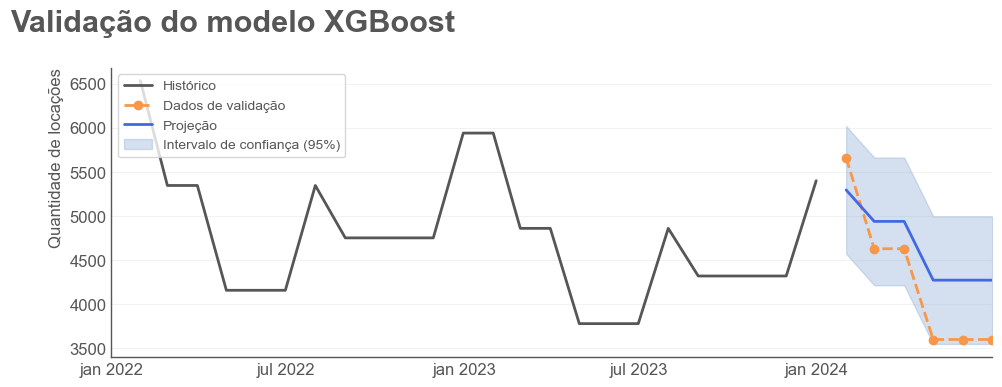

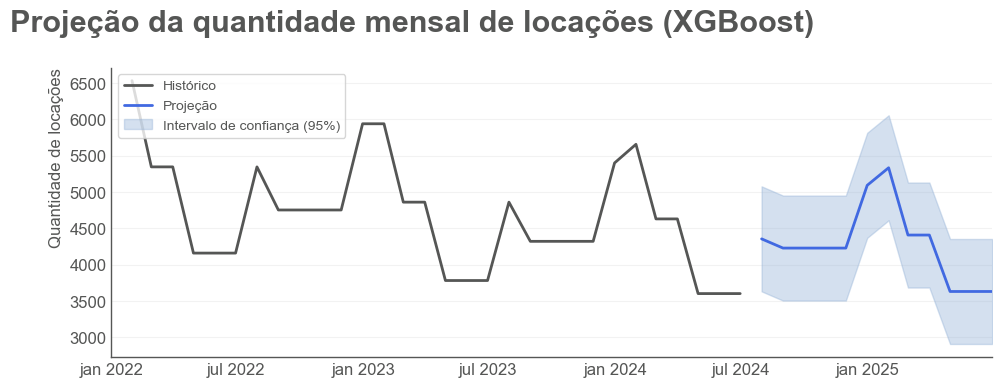

In [ ]:
# warnings.filterwarnings("ignore", module="xgboost")

# Auxiliary Functions


def validation_xgboost(X, y, param_grid, test_size=6, random_state=42):
    """
    Realiza o treinamento e avaliação de um modelo XGBoost com GridSearchCV.
    """
    # Divisão dos dados em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, shuffle=False
    )

    # Instanciação e configuração do GridSearchCV
    xgb_model = xgb.XGBRegressor(
        objective="reg:squarederror", random_state=random_state
    )
    grid_search = GridSearchCV(
        estimator=xgb_model,
        param_grid=param_grid,
        cv=3,
        n_jobs=-1,
        verbose=2,
        scoring="neg_mean_squared_error",
    )

    # Treinamento do modelo
    grid_search.fit(X_train, y_train)
    best_xgb = grid_search.best_estimator_
    print("\nMelhores parâmetros encontrados:", best_xgb)

    # Projeção e avaliação no conjunto de teste
    y_pred = grid_search.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / np.where(y_test == 0, 1, y_test))) * 100

    print("\nMétricas de Avaliação do Modelo XGBoost (período de teste):")
    print(f"  - MAE (Erro Absoluto Médio): {mae:.2f}")
    print(f"  - RMSE (Raiz do Erro Quadrático Médio): {rmse:.2f}")
    print(f"  - MAPE (Erro Percentual Absoluto Médio): {mape:.2f}%")

    # Cálculo do intervalo de confiança
    residuals = y_test - y_pred
    interval = 1.96 * np.std(residuals)
    lower_bound = y_pred - interval
    upper_bound = y_pred + interval

    return (
        X_train,
        X_test,
        y_train,
        y_test,
        y_pred,
        best_xgb,
        interval,
        lower_bound,
        upper_bound,
    )


def model_xgboost(
    X, y, best_params, interval, start_date="2024-07-01", end_date="2025-06-30"
):
    """
    Treina o modelo XGBoost final com todos os dados e projeta valores futuros.
    """
    # Treinamento do modelo final com todos os dados
    full_model = xgb.XGBRegressor(**best_params.get_params())
    full_model.fit(X, y)

    # Criação do DataFrame e features para o período futuro
    future_dates = pd.date_range(start=start_date, end=end_date, freq="ME")
    X_pred = pd.DataFrame(index=future_dates)

    X_pred["time_index"] = np.arange(
        len(df_monthly), len(df_monthly) + len(future_dates)
    )
    X_pred["month"] = X_pred.index.month
    X_pred["year"] = X_pred.index.year

    # Projeção dos valores
    y_pred = full_model.predict(X_pred[["time_index", "month", "year"]])

    # Cálculo do intervalo de confiança para a projeção
    lower_bound_future = y_pred - interval
    upper_bound_future = y_pred + interval

    return X_pred, y_pred, lower_bound_future, upper_bound_future


def config_prediction_plot(ax, title: str, y_label: str, min_date, max_date):
    """
    Aplica uma configuração de estilo específica a um eixo Matplotlib.
    """
    # Define os limites do eixo X e o formato das datas
    ax.set_xlim(min_date, max_date)
    date_format = mdates.DateFormatter("%b %Y")  # Formato ex: "Jan 2023"
    ax.xaxis.set_major_formatter(date_format)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))  # Marca a cada 6 meses

    # Estiliza os ticks e as bordas (spines) do gráfico
    ax.tick_params(color="#555655")
    ax.spines["bottom"].set_color("#555655")
    ax.spines["left"].set_color("#555655")
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    # Configura o grid
    ax.grid(True, axis="y", alpha=0.25)
    ax.xaxis.grid(False)

    # Estiliza os rótulos dos ticks (números nos eixos)
    plt.setp(
        [*ax.get_xticklabels(), *ax.get_yticklabels()], fontsize=12, color="#555655"
    )

    # Configura os rótulos dos eixos e a legenda
    ax.set_xlabel("")
    ax.set_ylabel(y_label, loc="top", fontsize=12, color="#555655")
    ax.legend(title="", labelcolor="#555655", loc="upper left", frameon=True)

    # Adiciona o título principal com posicionamento customizado
    ax.text(
        -0.115,
        1.125,
        title,
        transform=ax.transAxes,
        fontsize=22,
        fontweight="semibold",
        color="#555655",
    )
    plt.tight_layout()


def validation_xgboost_plot(
    X_train,
    X_test,
    y_train,
    y_test,
    y_pred,
    lower_bound,
    upper_bound,
    min_date,
    max_date,
):
    """
    Gera e salva o gráfico de validação do modelo.
    """
    fig, ax = plt.subplots(figsize=(10, 4))

    ax.plot(X_train.index, y_train, label="Histórico", color="#555655", linewidth=2)
    ax.plot(
        X_test.index,
        y_test,
        label="Dados de validação",
        color="#F79747",
        marker="o",
        linestyle="--",
        linewidth=2,
    )
    ax.plot(
        X_test.index,
        y_pred,
        label="Projeção",
        color="#4169E1",
        linewidth=2,
    )
    ax.fill_between(
        X_test.index,
        lower_bound,
        upper_bound,
        color="#94B2D7",
        alpha=0.4,
        label="Intervalo de confiança (95%)",
    )

    config_prediction_plot(
        ax,
        title="Validação do modelo XGBoost",
        y_label="Quantidade de locações",
        min_date=min_date,
        max_date=max_date,
    )

    # Salva a figura
    fig.savefig("../img/results/validation_xgboost.png", dpi=600, bbox_inches="tight")


def model_xgboost_plot(X, y, X_pred, y_pred, lower_bound, upper_bound, min_date):
    """
    Gera e exibe o gráfico com os dados históricos e a projeção futura.
    """
    max_date = X_pred.index.max()

    fig, ax = plt.subplots(figsize=(10, 4))

    ax.plot(
        X.index,
        y,
        label="Histórico",
        color="#555655",
        linewidth=2,
    )
    ax.plot(
        X_pred.index,
        y_pred,
        label="Projeção",
        color="#4169E1",
        linewidth=2,
    )
    ax.fill_between(
        X_pred.index,
        lower_bound,
        upper_bound,
        color="#94B2D7",
        alpha=0.4,
        label="Intervalo de confiança (95%)",
    )

    config_prediction_plot(
        ax,
        title="Projeção da quantidade mensal de locações (XGBoost)",
        y_label="Quantidade de locações",
        min_date=min_date,
        max_date=max_date,
    )

    # Salva a figura
    fig.savefig(
        "../img/results/prediction_amount_xgboost.png", dpi=600, bbox_inches="tight"
    )


# Execution
# Preparação e Engenharia de Atributos

df["Data de Início da Locação"] = pd.to_datetime(df["Data de Início da Locação"])
min_date = df["Data de Início da Locação"].min()
max_date = df["Data de Início da Locação"].max()

# Mudança da escala/granulidade do conjunto de dados
df_monthly = (
    df.set_index("Data de Início da Locação")
    .resample("ME")
    .agg({"ID do Contrato": "count"})
    .rename(columns={"ID do Contrato": "Quantidade_Locacoes"})
)

# Criação dos atributos a partir do índice de data
df_monthly["time_index"] = np.arange(len(df_monthly))  # Tendência temporal
df_monthly["month"] = df_monthly.index.month  # Sazonalidade mensal
df_monthly["year"] = df_monthly.index.year  # Sazonalidade anual

# Definição das variáveis preditoras (X) e alvo (y)
X = df_monthly[["time_index", "month", "year"]]
y = df_monthly["Quantidade_Locacoes"]

# Treinamento e Validação do Modelo com XGBoost e GridSearchCV

(
    X_train,
    X_test,
    y_train,
    y_test,
    y_pred,
    best_xgb,
    interval,
    lower_bound,
    upper_bound,
) = validation_xgboost(X, y, param_grid)
validation_xgboost_plot(
    X_train,
    X_test,
    y_train,
    y_test,
    y_pred,
    lower_bound,
    upper_bound,
    min_date,
    max_date,
)

# Projeção

X_pred, y_pred, lower_bound_future, upper_bound_future = model_xgboost(
    X, y, best_xgb, interval
)
model_xgboost_plot(
    X, y, X_pred, y_pred, lower_bound_future, upper_bound_future, min_date
)